In [472]:
import typing as tp
import sympy as sp
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import tqdm

In [816]:
display_style = "notebook"
save_figures = True


def show(expr, display_style: str=display_style):
    if display_style == "notebook":
        display(Latex("$$" + sp.latex(expr) + "$$"))
    elif display_style == "latex":
        print(sp.latex(expr))
    elif display_style == "pprint":
        print(sp.pprint(expr))
    else:
        raise ValueError(f"Unknown display style: {display_style}")


def set_axes_percent(ax=None, x=True, y=True):
    if ax is None:
        ax = plt.gca()
    if x:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    if y:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    return ax


colors = plt.cm.tab10.colors


def get_color(index):
    return colors[index % len(colors)]


def fill_between(
    ax: plt.Axes,
    x,
    y1,
    y2,
    c1,
    c2,
    marker="o",
    linestyle="dashed",
    label1=None,
    label2=None,
    alpha=0.3,
):
    x = x.astype(np.float64)
    y1 = y1.astype(np.float64)
    y2 = y2.astype(np.float64)
    ax.plot(x, y1, color=c1, marker=marker, linestyle=linestyle, label=label1)
    ax.plot(x, y2, color=c2, marker=marker, linestyle=linestyle, label=label2)
    ax.fill_between(x, y1, y2, where=(y1 >= y2), color=c1, alpha=alpha, interpolate=True)
    ax.fill_between(x, y1, y2, where=(y1 < y2), color=c2, alpha=alpha, interpolate=True)


def maybe_save(fig: plt.Figure, filename: str):
    if save_figures:
        fig.savefig('images/' + filename, bbox_inches="tight")

In [808]:
general_returns_symbol = sp.symbols("R")

leverage = sp.symbols("lambda")
base_tax_rate = sp.symbols("t")
capital_growth = sp.symbols("c")
investment_yield = sp.symbols("y")
interest_rate = sp.symbols("r")
max_leverage = sp.symbols("lambda_m")
max_tax_rate = sp.symbols("t_m")
cgt_discount = sp.symbols("Delta")

marginal_tax_rates = [
    sp.Rational(0, 100),
    # sp.Rational(16, 100),
    sp.Rational(18, 100),
    sp.Rational(32, 100),
    sp.Rational(39, 100),
    sp.Rational(47, 100),
]

default_values = {
    max_tax_rate: marginal_tax_rates[-1],
    max_leverage: 5,
    cgt_discount: sp.Rational(1, 2),
    interest_rate: sp.Rational(55, 1000),
}

marginal_tax_rates_np = np.array([m.evalf() for m in marginal_tax_rates])

levered_returns = leverage * (
    (1 - base_tax_rate) * investment_yield
    + (1 - (1 - cgt_discount) * base_tax_rate) * capital_growth
) - (leverage - 1) * interest_rate * (1 - base_tax_rate)
pre_tax_returns = levered_returns.subs(base_tax_rate, 0)
effective_tax_rate = (pre_tax_returns - levered_returns) / pre_tax_returns

show(sp.Eq(general_returns_symbol, levered_returns))
show(sp.Eq(general_returns_symbol, levered_returns.expand().collect([base_tax_rate, leverage])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

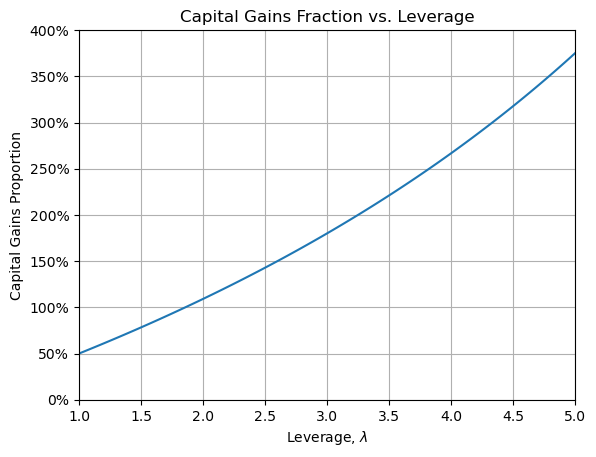

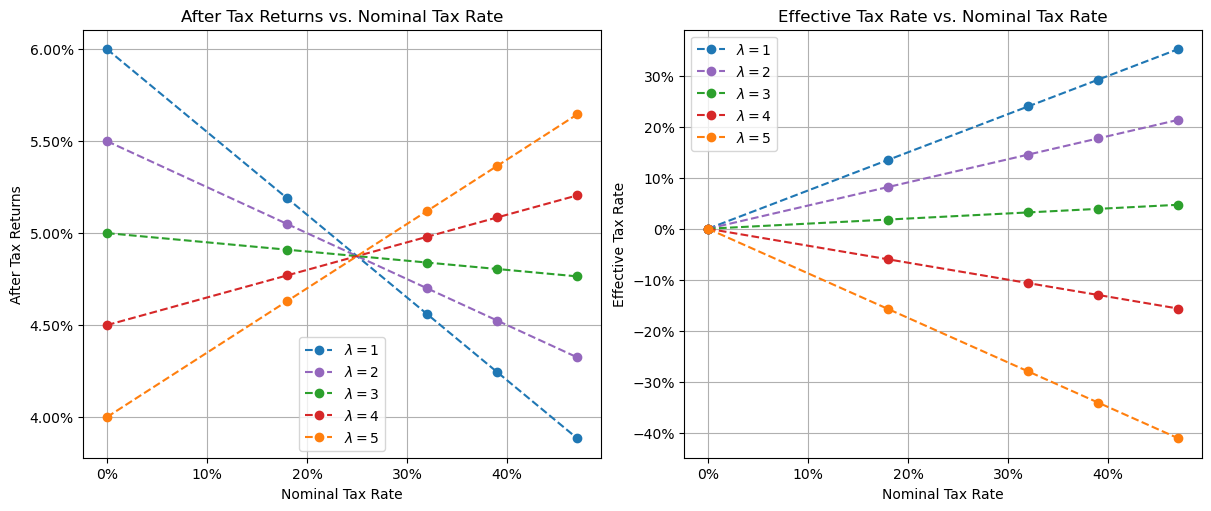

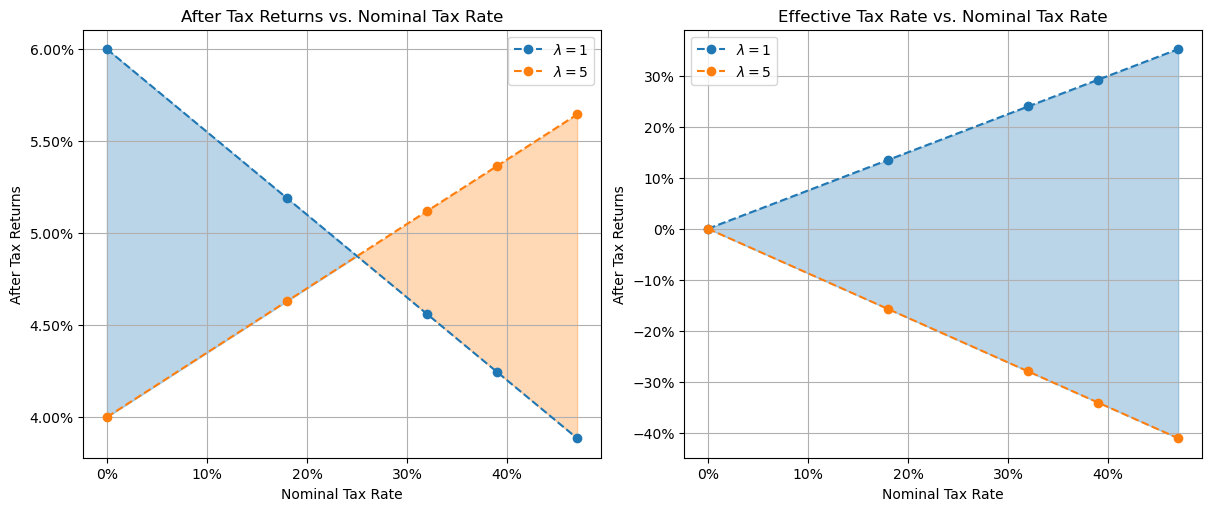

In [825]:
def vis():
    params = {
        capital_growth: 0.03,
        investment_yield: 0.03,
        interest_rate: 0.065,
    }

    capital_gains = leverage * capital_growth
    investment_income = leverage * investment_yield - (leverage - 1) * interest_rate
    capital_gains_frac = capital_gains / (capital_gains + investment_income)
    show(capital_gains_frac)
    capital_gains_frac_func = sp.lambdify(
        [leverage], capital_gains_frac.subs(params).subs(default_values), "numpy"
    )
    fig = plt.figure()
    ax = plt.gca()
    leverages = np.linspace(1, 5, 101)
    ax.plot(leverages, capital_gains_frac_func(leverages) * 100)
    ax.set_title("Capital Gains Fraction vs. Leverage")
    set_axes_percent(ax, x=False)
    ax.set_xlabel(f"Leverage, ${sp.latex(leverage)}$")
    ax.set_ylabel("Capital Gains Proportion")
    ax.set_xlim(1, 5)
    ax.set_ylim(0, 400)
    ax.grid(True)

    t = marginal_tax_rates_np
    num_leverages = 5
    all_colors = [get_color(i) for i in range(num_leverages)]
    all_colors[1], all_colors[-1] = all_colors[-1], all_colors[1]
    leverages = np.arange(1, 1 + num_leverages)

    general_returns_func = sp.lambdify(
        [leverage, base_tax_rate],
        levered_returns.subs(params).subs(default_values),
        "numpy",
    )
    effective_tax_rate_func = sp.lambdify(
        [leverage, base_tax_rate],
        effective_tax_rate.subs(params).subs(default_values),
        "numpy",
    )
    maybe_save(fig, 'capital-gains-fraction-vs-leverage.png')
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
    ax: plt.Axes = axes[0]
    ax.set_title("After Tax Returns vs. Nominal Tax Rate")
    set_axes_percent(ax)
    for i, lev in enumerate(leverages):
        y = general_returns_func(lev, t)
        color = all_colors[i]
        ax.plot(
            t * 100,
            y * 100,
            label=f"${sp.latex(leverage)}={lev}$",
            linestyle="dashed",
            color=color,
            marker="o",
        )
        # ax.hlines(general_returns_func(lev, 0) * 100, 0, 50, linestyles='dotted', color=color)
    ax.legend()
    ax.set_xlabel("Nominal Tax Rate")
    ax.set_ylabel("After Tax Returns")
    ax.grid(True)

    ax = axes[1]
    ax.set_title("Effective Tax Rate vs. Nominal Tax Rate")
    set_axes_percent(ax)
    for i, lev in enumerate(leverages):
        y = effective_tax_rate_func(lev, t)
        color = all_colors[i]
        ax.plot(
            t * 100,
            y * 100,
            label=f"${sp.latex(leverage)}={lev}$",
            linestyle="dashed",
            color=color,
            marker="o",
        )
    ax.legend()
    ax.set_xlabel("Nominal Tax Rate")
    ax.set_ylabel("Effective Tax Rate")
    ax.grid(True)
    maybe_save(fig, 'leveraged-rates-discrete.png')

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
    ax = axes[0]
    ax.set_title("After Tax Returns vs. Nominal Tax Rate")
    set_axes_percent(ax)
    fill_between(
        ax,
        t * 100,
        general_returns_func(leverages[0], t) * 100,
        general_returns_func(leverages[-1], t) * 100,
        all_colors[0],
        all_colors[-1],
        label1=f"${sp.latex(leverage)}={leverages[0]}$",
        label2=f"${sp.latex(leverage)}={leverages[-1]}$",
    )
    ax.legend()
    ax.set_xlabel("Nominal Tax Rate")
    ax.set_ylabel("After Tax Returns")
    ax.grid(True)

    ax = axes[1]
    ax.set_title("Effective Tax Rate vs. Nominal Tax Rate")
    set_axes_percent(ax)
    fill_between(
        ax,
        t * 100,
        effective_tax_rate_func(leverages[0], t) * 100,
        effective_tax_rate_func(leverages[-1], t) * 100,
        all_colors[0],
        all_colors[-1],
        label1=f"${sp.latex(leverage)}={leverages[0]}$",
        label2=f"${sp.latex(leverage)}={leverages[-1]}$",
    )
    ax.legend()
    ax.set_xlabel("Nominal Tax Rate")
    ax.set_ylabel("After Tax Returns")
    ax.grid(True)
    maybe_save(fig, 'leveraged-rates-bounds.png')


vis()

In [100]:
intersection_tax_rate_symbol = sp.symbols('t_+')
intersection_tax_rate = sp.solve(
    sp.Eq(levered_returns.subs(leverage, sp.symbols('lambda_1')), levered_returns.subs(leverage, sp.symbols('lambda_2'))),
    base_tax_rate,
)[0]
show(sp.Eq(intersection_tax_rate_symbol, intersection_tax_rate))

untaxed_leverage_symbol = sp.symbols('lambda_t0')
untaxed_leverage = sp.solve(sp.Eq(effective_tax_rate, 0), leverage)[0]
show(sp.Eq(untaxed_leverage_symbol, untaxed_leverage))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

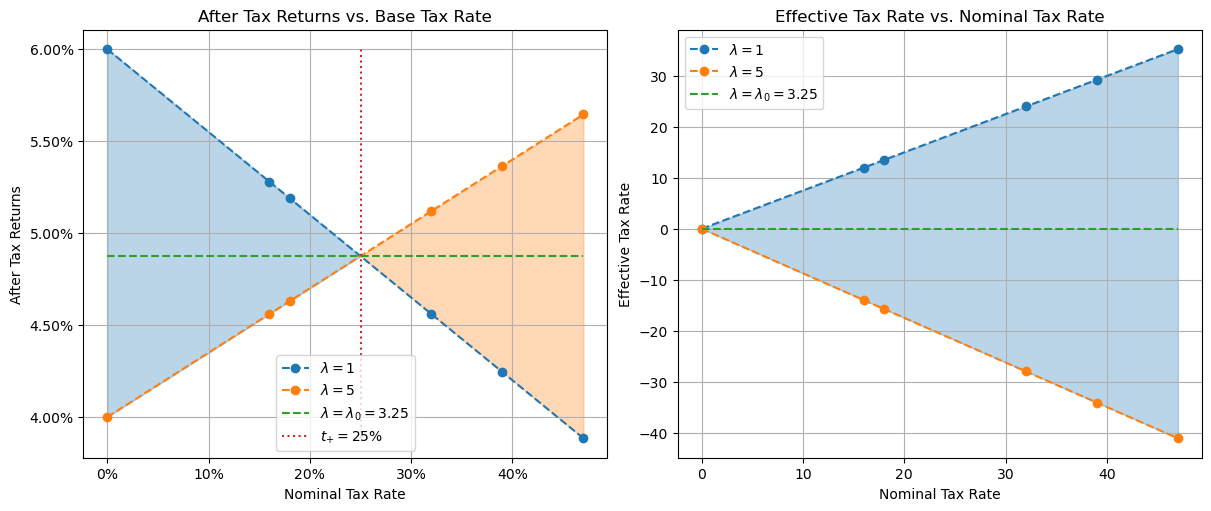

In [793]:
def vis():
    params = {
        capital_growth: 0.03,
        investment_yield: 0.03,
        interest_rate: 0.065,
    }
    returns_func = sp.lambdify(
        [leverage, base_tax_rate],
        levered_returns.subs(params).subs(default_values),
        "numpy",
    )
    returns_1 = returns_func(1, marginal_tax_rates_np)
    lambda_max = 5
    untaxed_leverage_val = untaxed_leverage.subs(params).subs(default_values).evalf()
    intersection_tax_rate_val = (
        intersection_tax_rate.subs(params).subs(default_values).evalf()
    )
    returns_untaxed = returns_func(untaxed_leverage_val, marginal_tax_rates_np)
    returns_max = returns_func(lambda_max, marginal_tax_rates_np)
    _, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
    ax: plt.Axes = axes[0]
    ax.set_title("After Tax Returns vs. Base Tax Rate")
    set_axes_percent(ax)
    fill_between(
        ax,
        marginal_tax_rates_np * 100,
        returns_1 * 100,
        returns_max * 100,
        c1=get_color(0),
        c2=get_color(1),
        label1=f"${sp.latex(leverage)}=1$",
        label2=f"${sp.latex(leverage)}={lambda_max}$",
    )
    ax.plot(
        marginal_tax_rates_np * 100,
        returns_untaxed * 100,
        color=get_color(2),
        linestyle="dashed",
        label=f"${sp.latex(leverage)}={sp.latex(untaxed_leverage_symbol)}={untaxed_leverage_val:.2f}$",
    )
    ax.vlines(
        intersection_tax_rate_val * 100,
        min(returns_1.min(), returns_max.min()) * 100,
        max(returns_1.max(), returns_max.max()) * 100,
        color=get_color(3),
        label=f"${sp.latex(intersection_tax_rate_symbol)}={intersection_tax_rate_val*100:.0f}\\%$",
        linestyle="dotted",
    )
    ax.set_xlabel("Nominal Tax Rate")
    ax.set_ylabel("After Tax Returns")
    ax.grid(True)
    ax.legend()

    ax = axes[1]
    ax.set_title("Effective Tax Rate vs. Nominal Tax Rate")

    effective_tax_rate_func = sp.lambdify(
        [leverage, base_tax_rate],
        effective_tax_rate.subs(params).subs(default_values),
        "numpy",
    )
    effective_tax_rate_1 = effective_tax_rate_func(1, marginal_tax_rates_np)
    effective_tax_rate_untaxed = effective_tax_rate_func(
        untaxed_leverage_val, marginal_tax_rates_np
    )
    effective_tax_rate_max = effective_tax_rate_func(lambda_max, marginal_tax_rates_np)
    fill_between(
        ax,
        marginal_tax_rates_np * 100,
        effective_tax_rate_1 * 100,
        effective_tax_rate_max * 100,
        c1=get_color(0),
        c2=get_color(1),
        label1=f"${sp.latex(leverage)}=1$",
        label2=f"${sp.latex(leverage)}={lambda_max}$",
    )
    ax.plot(
        marginal_tax_rates_np * 100,
        effective_tax_rate_untaxed * 100,
        color=get_color(2),
        linestyle="dashed",
        label=f"${sp.latex(leverage)}={sp.latex(untaxed_leverage_symbol)}={untaxed_leverage_val:.2f}$",
    )
    ax.set_xlabel("Nominal Tax Rate")
    ax.set_ylabel("Effective Tax Rate")
    ax.grid(True)
    ax.legend()


vis()

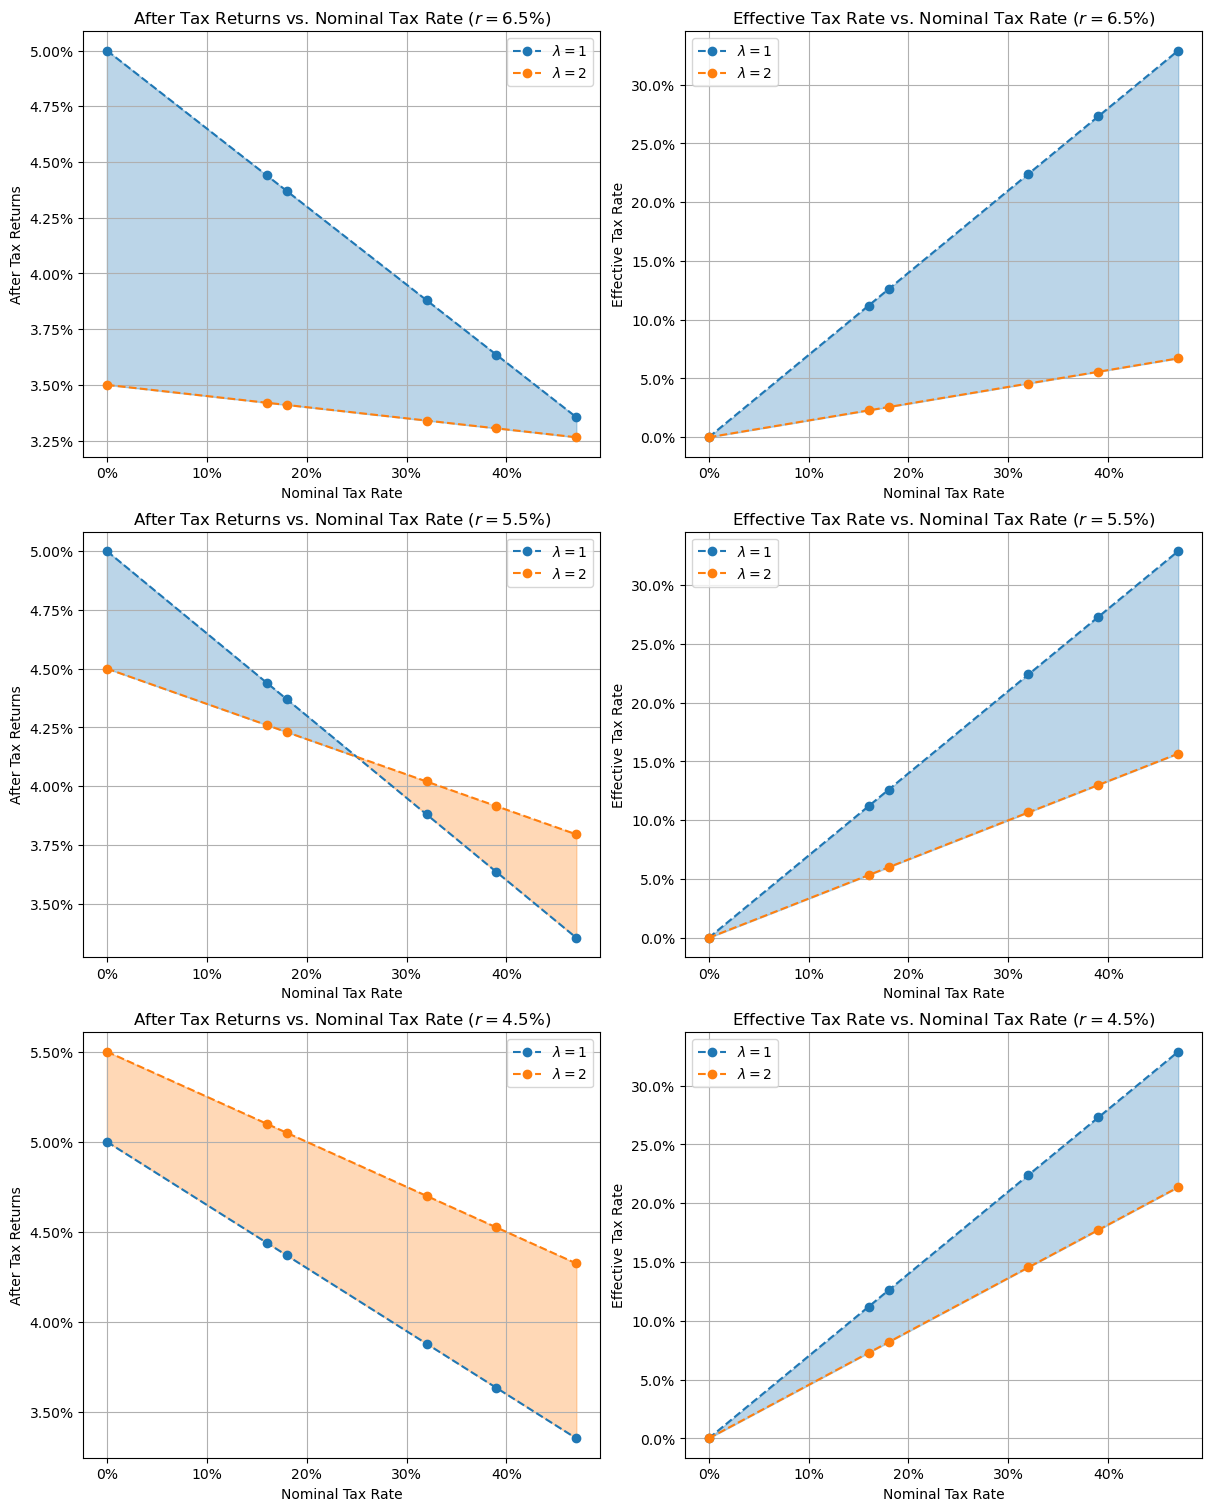

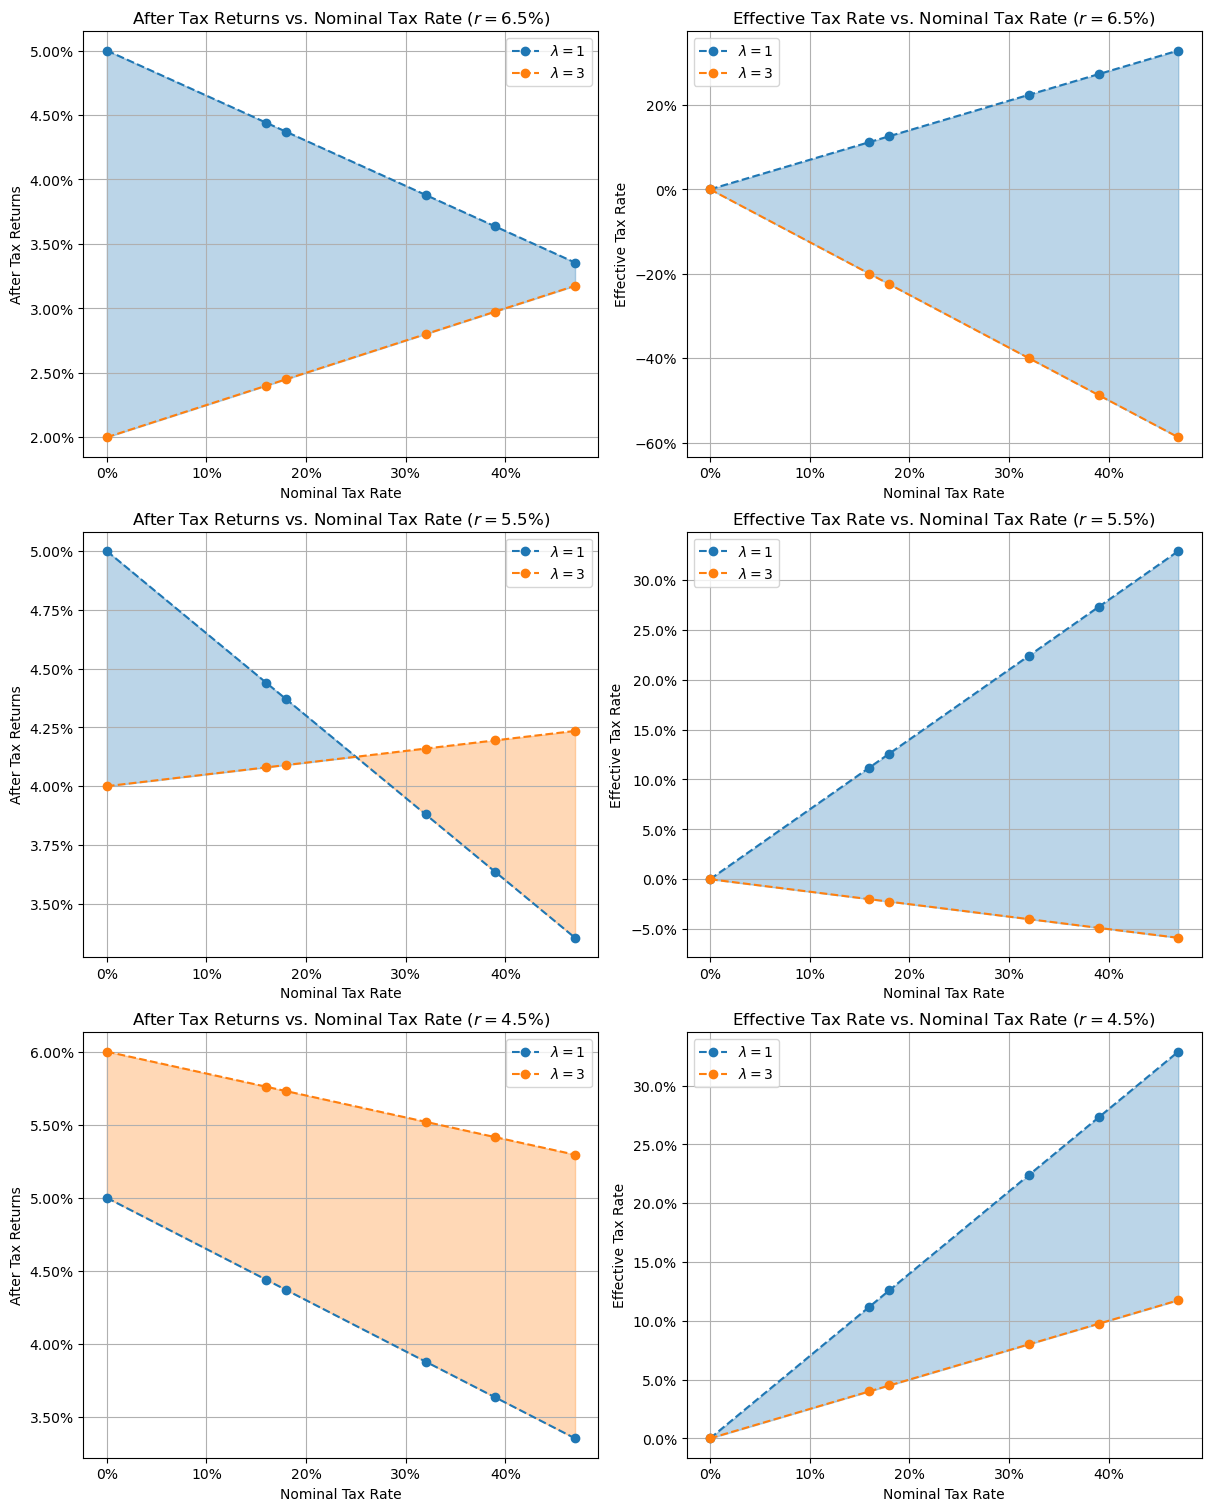

In [ ]:
def vis(lambda_max: float):
    params = {
        capital_growth: 0.03,
        investment_yield: 0.02,
    }
    rates = [0.065, 0.055, 0.045]
    _, axes = plt.subplots(3, 2, figsize=(12, 15), layout="constrained")
    for i, r in enumerate(rates):
        params[interest_rate] = r
        returns_func = sp.lambdify(
        [leverage, base_tax_rate],
        levered_returns.subs(params).subs(default_values),
        "numpy",
        )
        returns_1 = returns_func(1, marginal_tax_rates_np)
        returns_max = returns_func(lambda_max, marginal_tax_rates_np)
        ax: plt.Axes = axes[i, 0]
        ax.set_title(f"After Tax Returns vs. Nominal Tax Rate (${sp.latex(interest_rate)}={r*100:.1f}\\%$)")
        fill_between(
            ax,
            marginal_tax_rates_np * 100,
            returns_1 * 100,
            returns_max * 100,
            c1=get_color(0),
            c2=get_color(1),
            label1=f"${sp.latex(leverage)}=1$",
            label2=f"${sp.latex(leverage)}={lambda_max}$",
        )
        ax.set_xlabel("Nominal Tax Rate")
        ax.set_ylabel("After Tax Returns")
        set_axes_percent(ax)
        ax.legend()
        ax.grid(True)

        ax = axes[i, 1]
        effective_tax_rate_func = sp.lambdify(
            [leverage, base_tax_rate],
            effective_tax_rate.subs(params).subs(default_values),
            "numpy",
        )
        effective_tax_rate_1 = effective_tax_rate_func(1, marginal_tax_rates_np)
        effective_tax_rate_max = effective_tax_rate_func(lambda_max, marginal_tax_rates_np)
        ax.set_title(f"Effective Tax Rate vs. Nominal Tax Rate (${sp.latex(interest_rate)}={r*100:.1f}\\%$)")
        fill_between(
            ax,
            marginal_tax_rates_np * 100,
            effective_tax_rate_1 * 100,
            effective_tax_rate_max * 100,
            c1=get_color(0),
            c2=get_color(1),
            label1=f"${sp.latex(leverage)}=1$",
            label2=f"${sp.latex(leverage)}={lambda_max}$",
        )
        ax.set_xlabel("Nominal Tax Rate")
        ax.set_ylabel("Effective Tax Rate")
        set_axes_percent(ax)
        ax.legend()
        ax.grid(True)

vis(lambda_max=2)
vis(lambda_max=3)

In [1027]:
shares_capital_growth = sp.symbols("c_s")
shares_yield = sp.symbols("y_s")
shares_returns_symbol = sp.symbols("R_s")

shares_params = {
    leverage: 1,
    capital_growth: shares_capital_growth,
    investment_yield: shares_yield,
}
shares_returns = levered_returns.subs(shares_params)

housing_returns_symbol = sp.symbols("R_h")
housing_capital_growth = sp.symbols("c_h")
housing_yield = sp.symbols("y_h")
housing_params = {
    capital_growth: housing_capital_growth,
    investment_yield: housing_yield,
}
housing_returns = levered_returns.subs(housing_params)
wages_growth = sp.symbols("w")

default_values.update(
    {
        # https://www.abc.net.au/news/2025-11-02/house-prices-climbing-for-generation/105954416
        wages_growth: sp.Rational(37, 1000), 
        shares_capital_growth: sp.Rational(5, 100),
        shares_yield: sp.Rational(3, 100),
    }
)

model_params = {housing_capital_growth: wages_growth}
housing_yield_equilibrium_symbol = sp.symbols("y_h^*")

housing_yield_equilibrium = sp.solve(
    sp.Eq(
        shares_returns, housing_returns.subs({leverage: max_leverage, **model_params})
    ).subs(base_tax_rate, max_tax_rate),
    housing_yield,
)[0]
unlevered_housing_yield_equilibrium = sp.solve(
    sp.Eq(
        shares_returns, housing_returns.subs({leverage: 1, **model_params})
    ).subs(base_tax_rate, max_tax_rate),
    housing_yield,
)[0]

model_params[housing_yield] = housing_yield_equilibrium
show(sp.Eq(housing_yield_equilibrium_symbol, housing_yield_equilibrium.collect(interest_rate)))

owner_occupier_returns_symbol = sp.symbols("R_o")
owner_occupier_returns = housing_returns.subs(base_tax_rate, 0)


<IPython.core.display.Latex object>

y^{*}_{h} = \frac{- \Delta c_{s} t_{m} + \Delta \lambda_{m} t_{m} w + c_{s} t_{m} - c_{s} - \lambda_{m} t_{m} w + \lambda_{m} w + r \left(\lambda_{m} t_{m} - \lambda_{m} - t_{m} + 1\right) + t_{m} y_{s} - y_{s}}{\lambda_{m} \left(t_{m} - 1\right)}


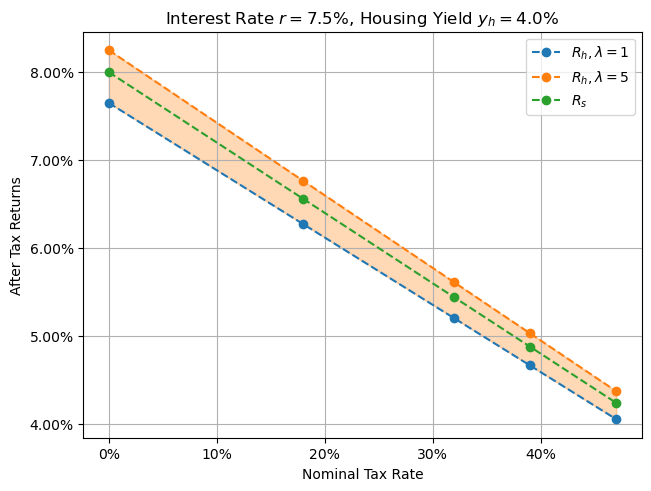

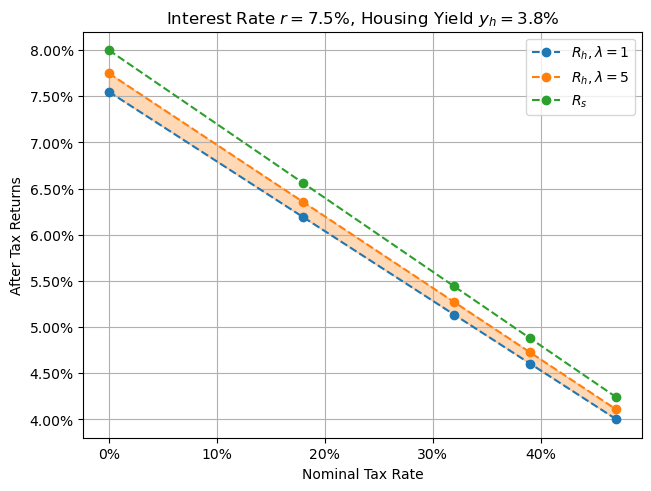

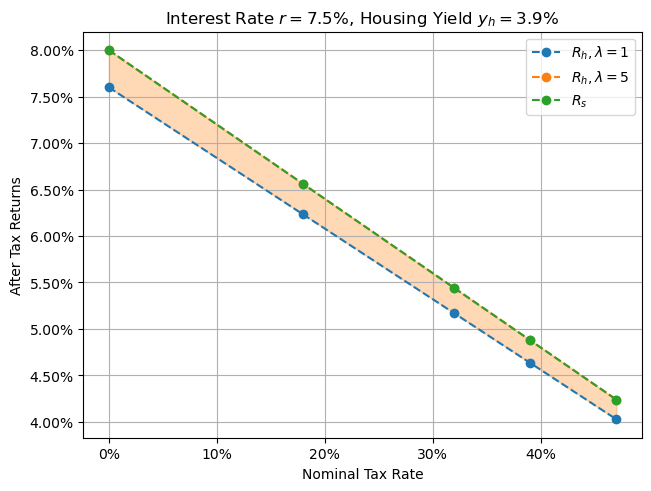

In [912]:
def vis(interest_rate_val: float, is_high_interest: bool, yield_diff: float):
    vals = default_values.copy()
    vals[cgt_discount] = 0
    vals[interest_rate] = interest_rate_val
    if is_high_interest:
        equilibrium_val = unlevered_housing_yield_equilibrium.subs(vals).evalf()
    else:
        equilibrium_val = housing_yield_equilibrium.subs(vals).evalf()

    yield_vals = [equilibrium_val + yield_diff, equilibrium_val - yield_diff, equilibrium_val]

    housing_returns_func = sp.lambdify(
        [housing_yield, leverage, base_tax_rate],
        housing_returns.subs(housing_capital_growth, wages_growth).subs(vals),
        "numpy",
    )
    shares_returns_func = sp.lambdify(
        [base_tax_rate],
        shares_returns.subs(vals),
        "numpy",
    )

    x = marginal_tax_rates_np * 100
    max_leverage_val = default_values[max_leverage]
    for i, y_h in enumerate(yield_vals):
        fig = plt.figure(layout="constrained")
        ax = plt.gca()
        h1 = housing_returns_func(y_h, 1, marginal_tax_rates_np) * 100
        h2 = housing_returns_func(y_h, max_leverage_val, marginal_tax_rates_np) * 100
        s = shares_returns_func(marginal_tax_rates_np) * 100
        fill_between(
            ax,
            x,
            h1,
            h2,
            c1=get_color(0),
            c2=get_color(1),
            label1=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=1$",
            label2=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=5$",
        )
        ax.plot(
            x,
            s,
            color=get_color(2),
            marker="o",
            label=f"${sp.latex(shares_returns_symbol)}$",
            linestyle="dashed",
        )
        ax.set_title(
            f"Interest Rate ${sp.latex(interest_rate)}={vals[interest_rate]*100:.1f}\\%$, "
            f"Housing Yield ${sp.latex(housing_yield)}={y_h*100:.1f}\\%$"
        )
        ax.set_xlabel("Nominal Tax Rate")
        ax.set_ylabel("After Tax Returns")
        set_axes_percent(ax)
        ax.legend()
        ax.grid(True)
        maybe_save(fig, f'transition-to-equilibrium-{i}.png')

# 9% interest, 4.5% equilibrium (4.4, 4.6)
# 8.5% interest, 4.3% equilibrium (4.2, 4.4)
# 7.5% interest, 3.9% equilibrium (3.8, 4.0)
# 7% interest, 3.5% 

vis(0.085, True, 0.003)
# vis(0.075, False, 0.0005)

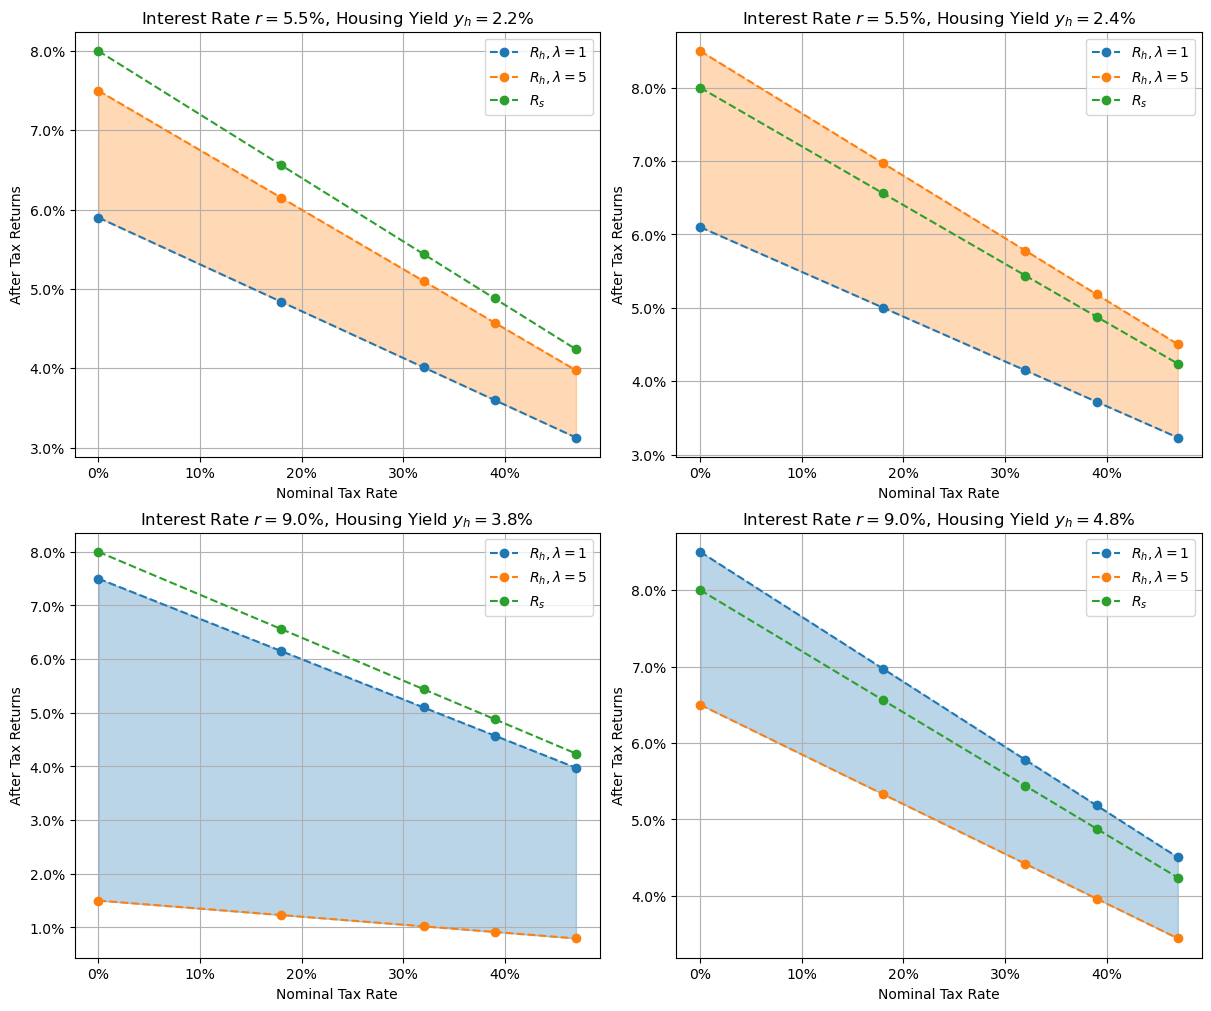

In [943]:
def vis():
    vals = default_values.copy()
    vals[cgt_discount] = 0
    del vals[interest_rate]

    housing_returns_func = sp.lambdify(
        [interest_rate, housing_yield, leverage, base_tax_rate],
        housing_returns.subs(housing_capital_growth, wages_growth).subs(vals),
        "numpy",
    )
    shares_returns_func = sp.lambdify(
        [base_tax_rate],
        shares_returns.subs(vals),
        "numpy",
    )
    s = shares_returns_func(marginal_tax_rates_np) * 100

    x = marginal_tax_rates_np * 100
    max_leverage_val = default_values[max_leverage]
    
    def do_plot(ax: plt.Axes, interest_rate_val: float, y_h: float):
        h1 = housing_returns_func(interest_rate_val, y_h, 1, marginal_tax_rates_np) * 100
        h2 = housing_returns_func(interest_rate_val, y_h, max_leverage_val, marginal_tax_rates_np) * 100
        
        fill_between(
            ax,
            x,
            h1,
            h2,
            c1=get_color(0),
            c2=get_color(1),
            label1=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=1$",
            label2=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=5$",
        )
        ax.plot(
            x,
            s,
            color=get_color(2),
            marker="o",
            label=f"${sp.latex(shares_returns_symbol)}$",
            linestyle="dashed",
        )
        ax.set_title(
            f"Interest Rate ${sp.latex(interest_rate)}={interest_rate_val*100:.1f}\\%$, "
            f"Housing Yield ${sp.latex(housing_yield)}={y_h*100:.1f}\\%$"
        )
        ax.set_xlabel("Nominal Tax Rate")
        ax.set_ylabel("After Tax Returns")
        set_axes_percent(ax)
        ax.legend()
        ax.grid(True)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), layout="constrained")
    do_plot(axes[0, 0], 0.055, 0.022)
    do_plot(axes[0, 1], 0.055, 0.024)
    do_plot(axes[1, 0], 0.09, 0.038)
    do_plot(axes[1, 1], 0.09, 0.048)
    maybe_save(fig, 'near-equilibrium-no-cgt.png')

vis()

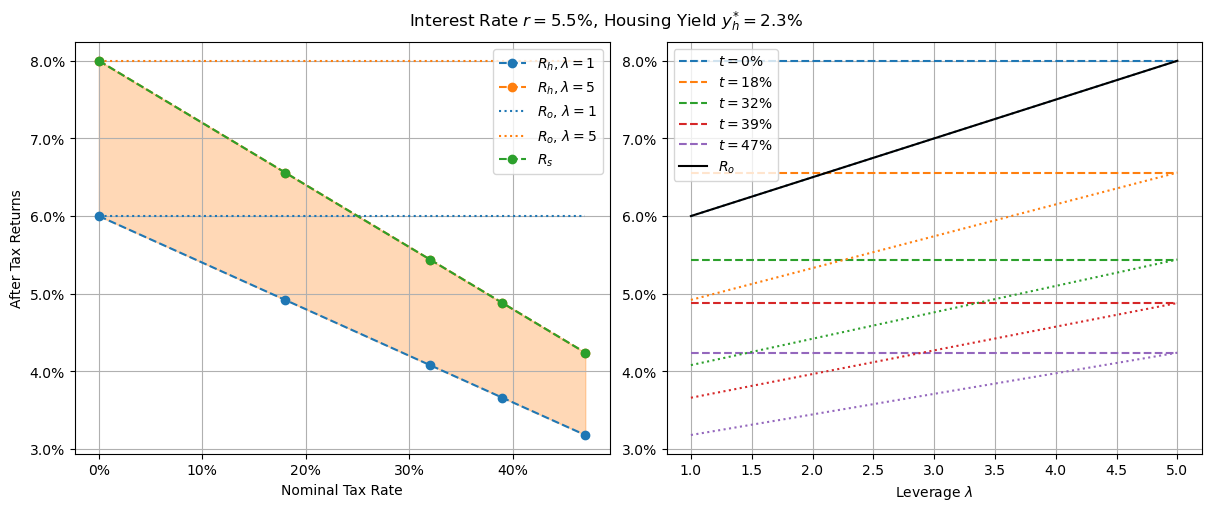

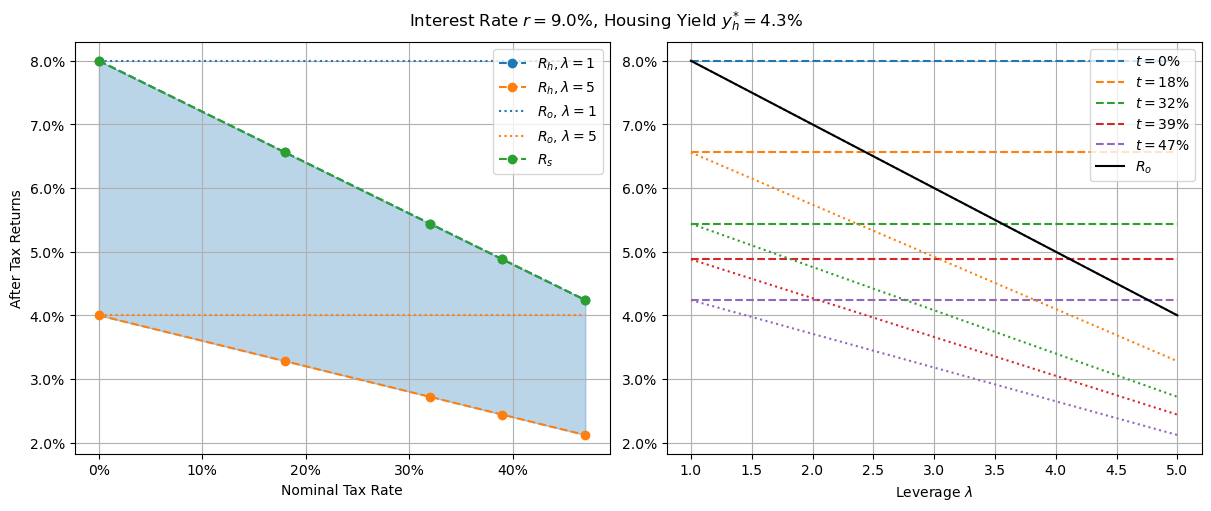

In [950]:
def vis():
    vals = default_values.copy()
    vals[cgt_discount] = 0
    del vals[interest_rate]

    critical_interest_rate = float(
        (shares_capital_growth + shares_yield).subs(vals).evalf()
    )
    # high interest rate environment
    high_interest_equilibrium_housing_yield = sp.solve(
        sp.Eq(housing_returns.subs(leverage, 1), shares_returns),
        housing_yield,
    )[0]
    housing_returns_func = sp.lambdify(
        [interest_rate, housing_yield, leverage, base_tax_rate],
        housing_returns.subs(housing_capital_growth, wages_growth).subs(vals),
        "numpy",
    )
    shares_returns_func = sp.lambdify(
        [base_tax_rate],
        shares_returns.subs(vals),
        "numpy",
    )

    x = marginal_tax_rates_np * 100
    max_leverage_val = default_values[max_leverage]
    max_leverage_plot_val = max_leverage_val
    s = shares_returns_func(marginal_tax_rates_np) * 100
    for i, (rate, label) in enumerate(
        [
            (critical_interest_rate - 0.025, "low"),
            (critical_interest_rate + 0.01, "high"),
        ]
    ):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
        if rate > critical_interest_rate:
            y_h = (
                high_interest_equilibrium_housing_yield.subs(
                    {
                        interest_rate: rate,
                        housing_capital_growth: wages_growth,
                        base_tax_rate: max_tax_rate,
                    }
                )
                .subs(vals)
                .evalf()
            )
        else:
            y_h = (
                housing_yield_equilibrium.subs(
                    {
                        interest_rate: rate,
                        housing_capital_growth: wages_growth,
                        base_tax_rate: max_tax_rate,
                    }
                )
                .subs(vals)
                .evalf()
            )
        fig.suptitle(
            f"Interest Rate ${sp.latex(interest_rate)}={rate*100:.1f}\\%$, "
            f"Housing Yield ${sp.latex(housing_yield_equilibrium_symbol)}={y_h*100:.1f}\\%$"
        )
        ax: plt.Axes = axes[0]
        h1 = housing_returns_func(rate, y_h, 1, marginal_tax_rates_np) * 100
        h2 = (
            housing_returns_func(rate, y_h, max_leverage_val, marginal_tax_rates_np)
            * 100
        )
        fill_between(
            ax,
            x,
            h1,
            h2,
            c1=get_color(0),
            c2=get_color(1),
            label1=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=1$",
            label2=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=5$",
        )
        ax.hlines(
            h1[0],
            x[0],
            x[-1],
            color=get_color(0),
            linestyle="dotted",
            label=f"${sp.latex(owner_occupier_returns_symbol)}$, ${sp.latex(leverage)}=1$",
        )
        ax.hlines(
            h2[0],
            x[0],
            x[-1],
            color=get_color(1),
            linestyle="dotted",
            label=f"${sp.latex(owner_occupier_returns_symbol)}$, ${sp.latex(leverage)}={vals[max_leverage]}$",
        )
        ax.plot(
            x,
            s,
            color=get_color(2),
            marker="o",
            label=f"${sp.latex(shares_returns_symbol)}$",
            linestyle="dashed",
        )
        ax.set_xlabel("Nominal Tax Rate")
        ax.set_ylabel("After Tax Returns")
        set_axes_percent(ax)
        ax.legend()
        ax.grid(True)

        ax = axes[1]
        for i, si in enumerate(s):
            ax.hlines(
                si,
                1,
                max_leverage_plot_val,
                color=get_color(i),
                linestyle="dashed",
                # label=f"${sp.latex(shares_returns_symbol)}$ at ${base_tax_rate}={marginal_tax_rates_np[i]*100:.0f}\\%$",
                label=f"${base_tax_rate}={marginal_tax_rates_np[i]*100:.0f}\\%$",
            )
        for i, tax_rate in enumerate(marginal_tax_rates_np):
            leverage_vals = np.array([1, max_leverage_plot_val])
            housing_returns_vals = (
                housing_returns_func(rate, y_h, leverage_vals, tax_rate) * 100
            )
            ax.plot(
                leverage_vals,
                housing_returns_vals,
                color=get_color(i),
                linestyle="dotted",
                # label=f"${sp.latex(housing_returns_symbol)}$ at ${base_tax_rate}={tax_rate*100:.0f}\\%$",
            )
        ax.set_xlabel(f"Leverage ${sp.latex(leverage)}$")
        leverage_vals = np.array([1, max_leverage_plot_val])
        set_axes_percent(ax, x=False)
        ax.plot(
            leverage_vals,
            housing_returns_func(rate, y_h, leverage_vals, 0) * 100,
            color="black",
            label=f"${sp.latex(owner_occupier_returns_symbol)}$",
        )
        ax.legend()
        ax.grid(True)
        maybe_save(fig, "equilibrium-" + label + "-interest-no-cgt.png")


vis()

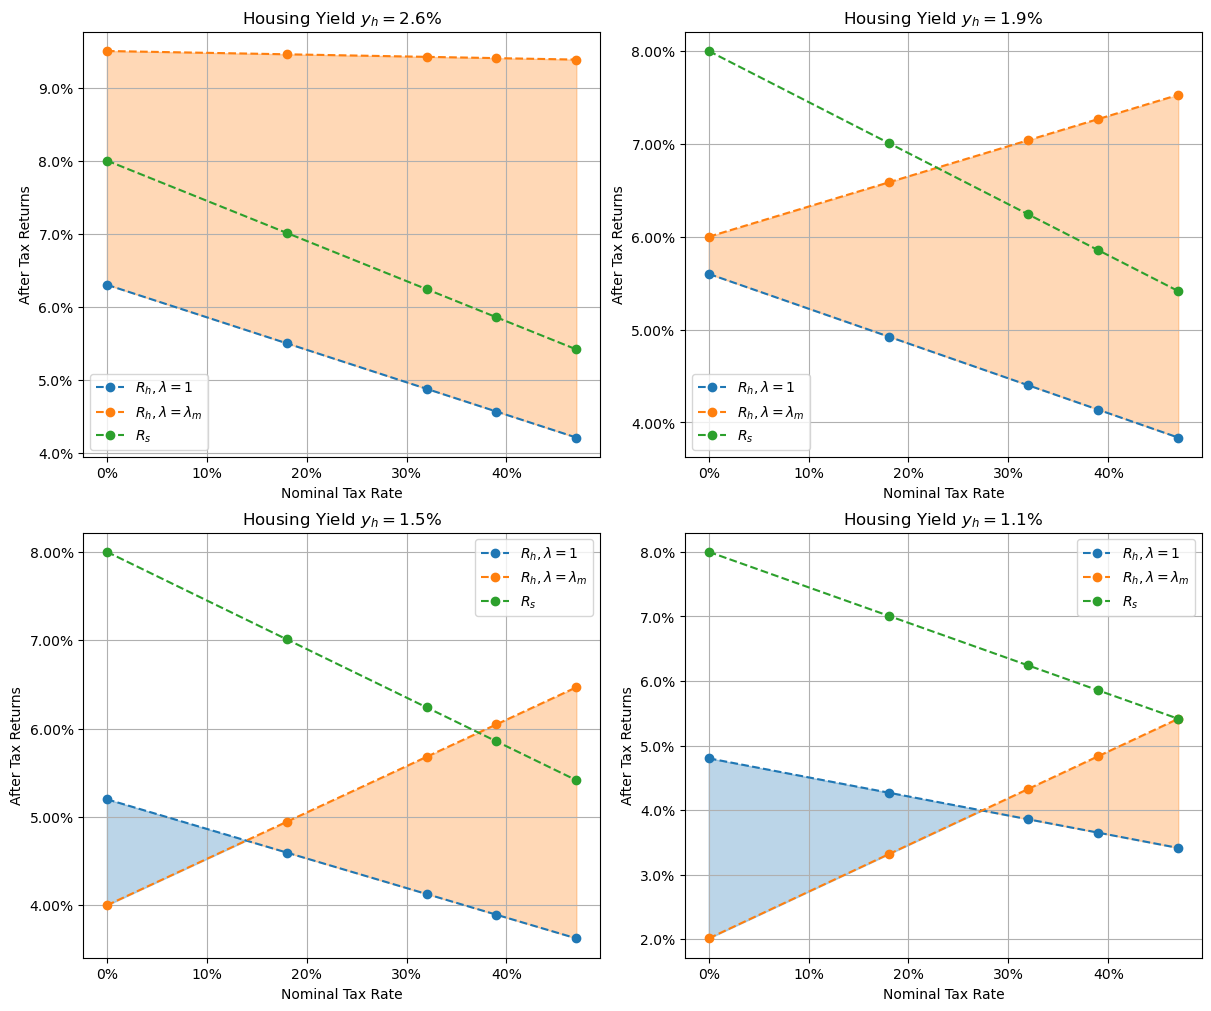

In [934]:
def vis():
    equilibrium_val = housing_yield_equilibrium.subs(default_values).evalf()
    yield_vals = [0.026, 0.019, 0.015, equilibrium_val]

    housing_returns_func = sp.lambdify(
        [housing_yield, leverage, base_tax_rate],
        housing_returns.subs(housing_capital_growth, wages_growth).subs(default_values),
        "numpy",
    )
    shares_returns_func = sp.lambdify(
        [base_tax_rate],
        shares_returns.subs(default_values),
        "numpy",
    )
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), layout="constrained")
    axes = axes.flatten()
    x = marginal_tax_rates_np * 100
    max_leverage_val = default_values[max_leverage]
    for i, y_h in enumerate(yield_vals):
        ax: plt.Axes = axes[i]
        h1 = housing_returns_func(y_h, 1, marginal_tax_rates_np) * 100
        h2 = housing_returns_func(y_h, max_leverage_val, marginal_tax_rates_np) * 100
        s = shares_returns_func(marginal_tax_rates_np) * 100
        fill_between(
            ax,
            x,
            h1,
            h2,
            c1=get_color(0),
            c2=get_color(1),
            label1=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=1$",
            label2=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}={sp.latex(max_leverage)}$",
        )
        ax.plot(x, s, color=get_color(2), marker='o', label=f"${sp.latex(shares_returns_symbol)}$", linestyle="dashed")
        ax.set_title(f"Housing Yield ${sp.latex(housing_yield)}={y_h*100:.1f}\\%$")
        ax.set_xlabel("Nominal Tax Rate")
        ax.set_ylabel("After Tax Returns")
        set_axes_percent(ax)
        ax.legend()
        ax.grid(True)
    maybe_save(fig, 'transition-to-equilibrium.png')


vis()

In [569]:
flat_interest_rate_symbol = sp.symbols("r_0")

flat_interest_rate = sp.solve(
    sp.Eq(intersection_tax_rate.subs(housing_params).subs(model_params), 0),
    interest_rate,
)[0]

show(sp.Eq(flat_interest_rate_symbol, flat_interest_rate))
show(sp.Eq(flat_interest_rate_symbol, flat_interest_rate.subs(default_values).evalf()))

final_ownership_rate_symbol = sp.symbols("r_*")
final_ownership_rate = sp.solve(
    sp.Eq(
        housing_returns.subs(model_params).subs({base_tax_rate: 0, leverage: 1}),
        shares_returns.subs(base_tax_rate, max_tax_rate),
    ),
    interest_rate,
)[0]
show(sp.Eq(final_ownership_rate_symbol, final_ownership_rate))
show(sp.Eq(final_ownership_rate_symbol, final_ownership_rate.subs(default_values).evalf()))

model_boundary_rate_symbol = sp.symbols("r_b")
model_boundary_rate = sp.solve(
    sp.Eq(
        housing_returns.subs(model_params).subs({base_tax_rate: max_tax_rate, leverage: max_leverage}),
        housing_returns.subs(model_params).subs({base_tax_rate: max_tax_rate, leverage: 1}),
    ), interest_rate
)[0]
show(sp.Eq(model_boundary_rate_symbol, model_boundary_rate))
show(sp.Eq(model_boundary_rate_symbol, model_boundary_rate.subs(default_values).evalf()))

show(sp.Eq(sp.symbols("R_hm"), housing_returns.subs(model_params).subs(leverage, max_leverage).expand().simplify().collect(base_tax_rate)))
critical_discount = sp.solve(sp.Eq(sp.poly(housing_returns.subs(model_params).subs(leverage, max_leverage).expand(), base_tax_rate).nth(1), 0), cgt_discount)[0]
critical_discount = sp.numer(critical_discount).factor() / sp.denom(critical_discount)
show(sp.Eq(sp.symbols("Delta_*"), critical_discount))
show(sp.Eq(sp.symbols("Delta_*"), critical_discount.subs(default_values).evalf()))

# show(sp.solve(sp.Eq(housing_returns.subs(model_params).subs(leverage, 1), 0), base_tax_rate)[0])
show(housing_returns.subs(model_params).subs(leverage, 1).expand().simplify().collect(base_tax_rate))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

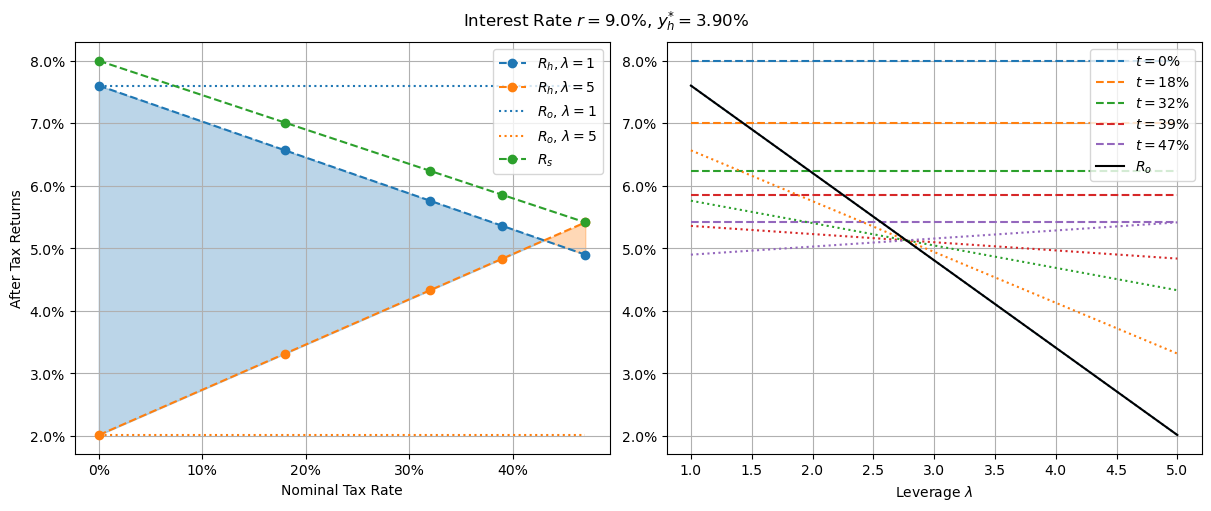

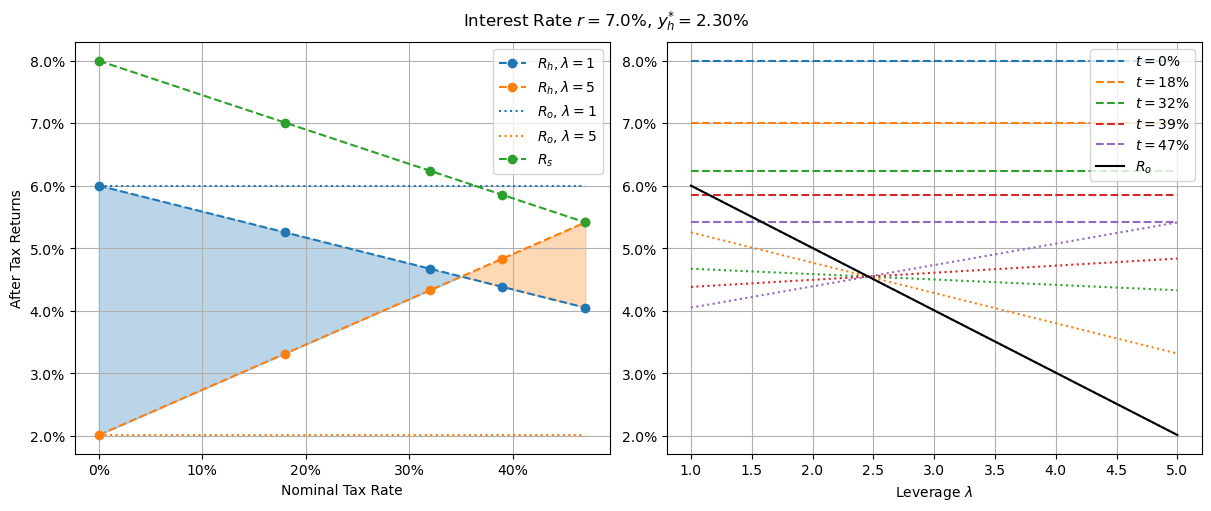

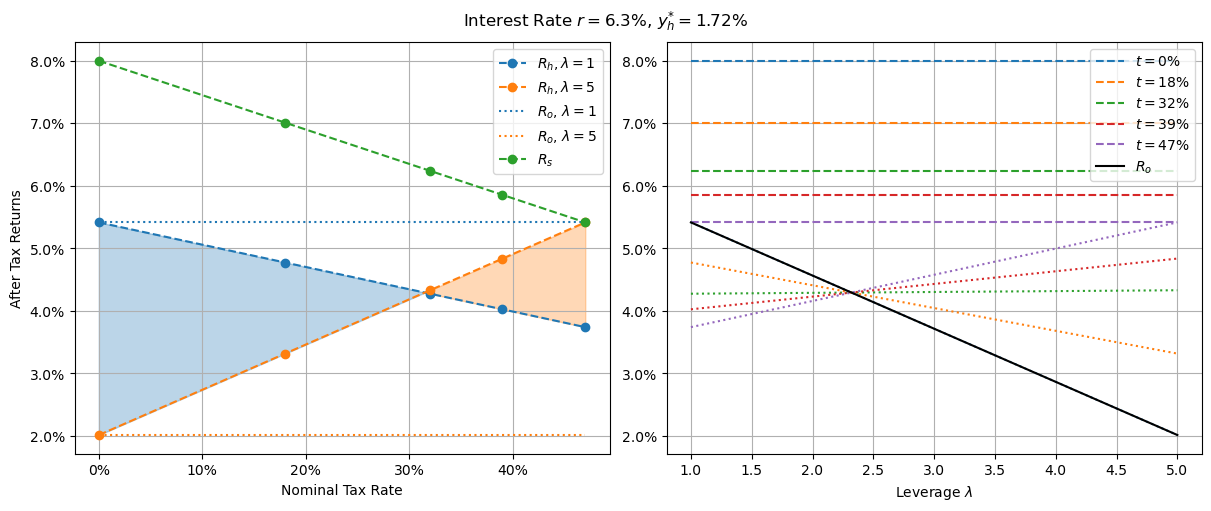

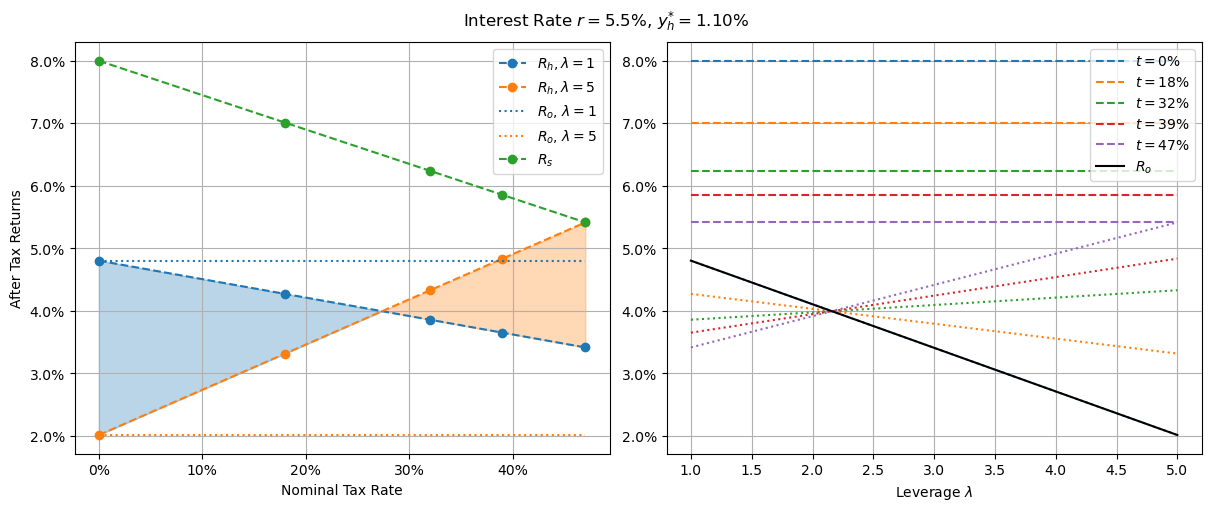

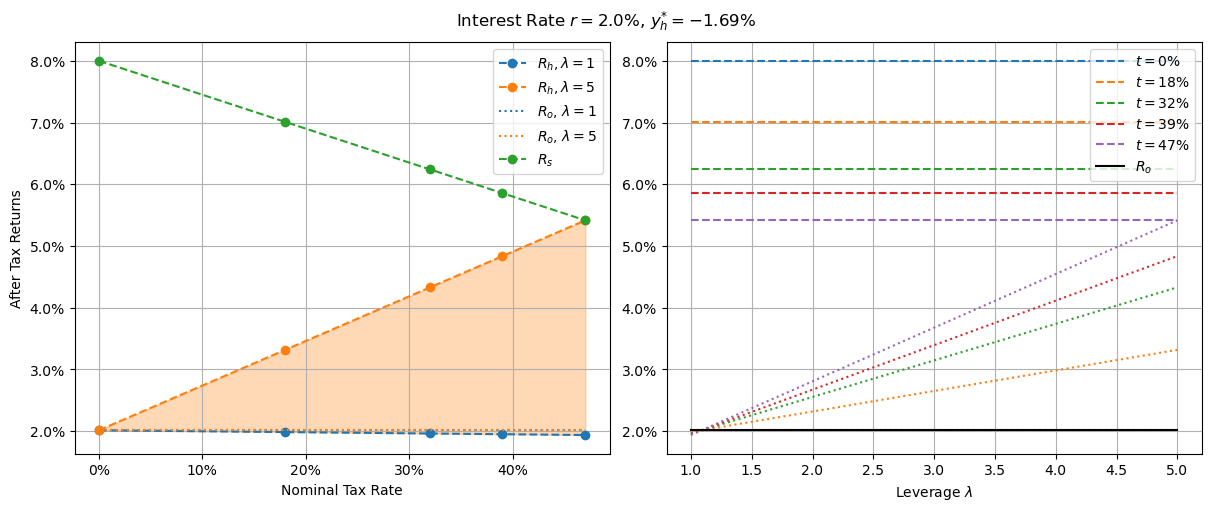

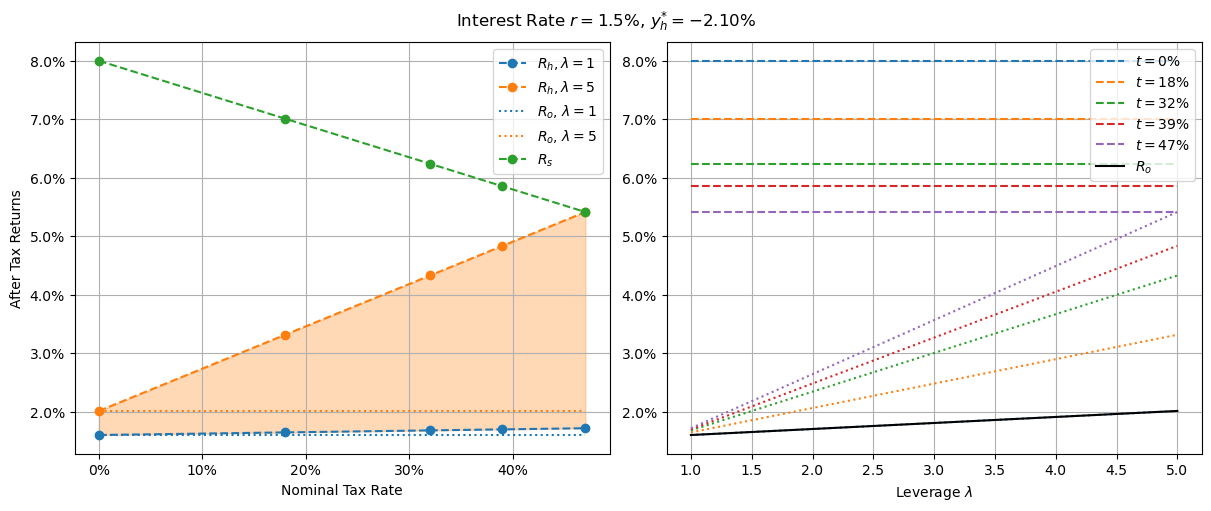

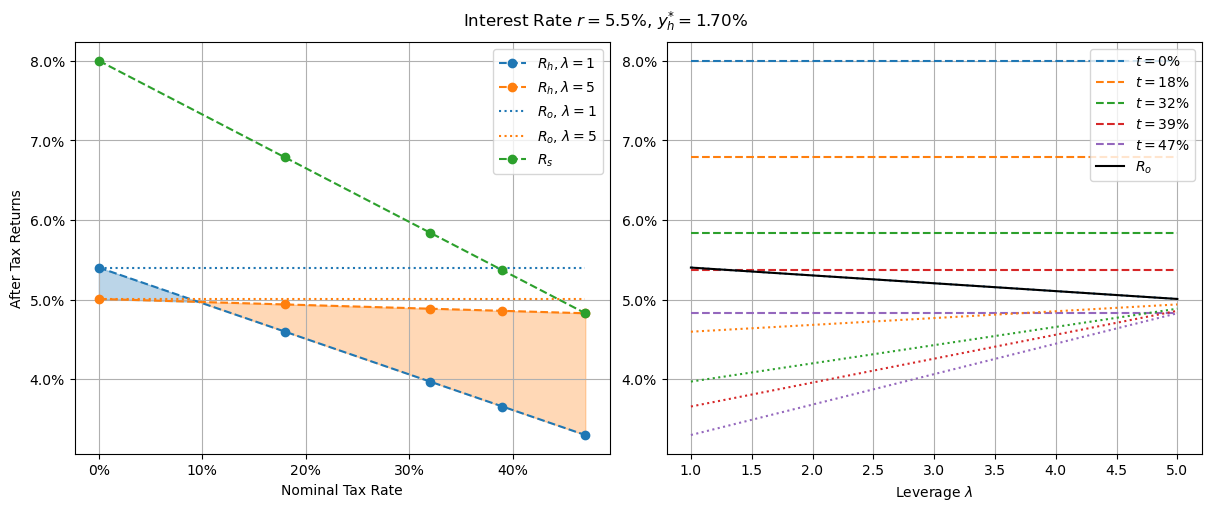

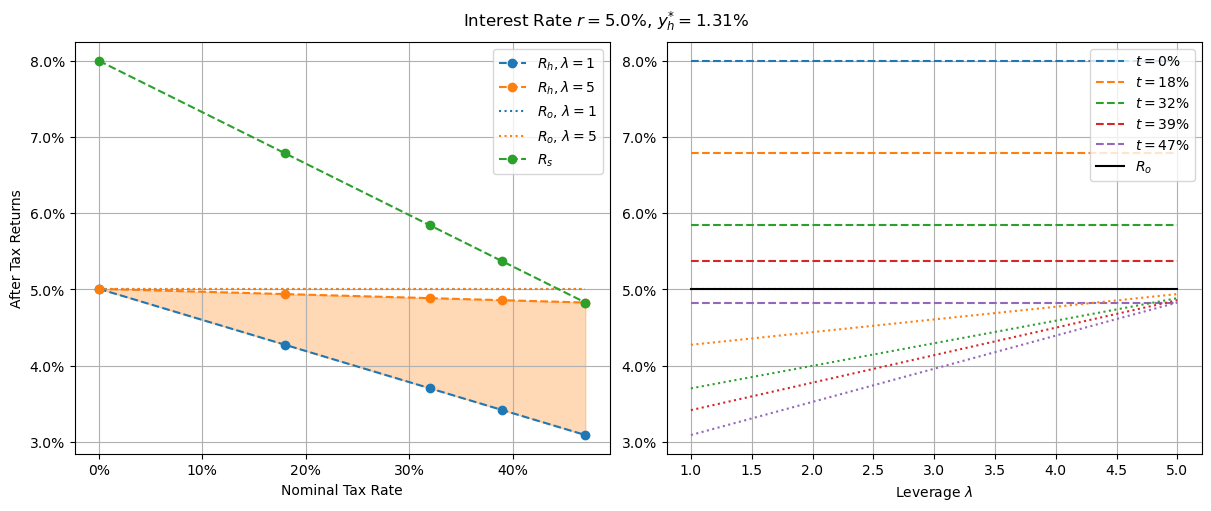

In [1014]:
def vis():
    vals = default_values.copy()
    del vals[interest_rate]
    del vals[cgt_discount]

    housing_returns_func = sp.lambdify(
        [cgt_discount, interest_rate, leverage, base_tax_rate],
        housing_returns.subs(model_params).subs(vals),
        "numpy",
    )
    shares_returns_func = sp.lambdify(
        [cgt_discount, base_tax_rate],
        shares_returns.subs(vals),
        "numpy",
    )
    equilibrium_func = sp.lambdify(
        [cgt_discount, interest_rate], housing_yield_equilibrium.subs(vals)
    )
    x = marginal_tax_rates_np * 100
    max_leverage_val = vals[max_leverage]
    # max_leverage_plot_val = 20
    max_leverage_plot_val = max_leverage_val

    def do_plots(rate: float, cgt_discount_val: float = 0.5):
        s = shares_returns_func(cgt_discount_val, marginal_tax_rates_np) * 100

        fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
        equilibrium_val = equilibrium_func(cgt_discount_val, rate)

        fig.suptitle(f"Interest Rate ${sp.latex(interest_rate)}={rate*100:.1f}\\%$, ${sp.latex(housing_yield_equilibrium_symbol)}={equilibrium_val*100:.2f}\\%$")
        ax: plt.Axes = axes[0]
        h1 = housing_returns_func(cgt_discount_val, rate, 1, marginal_tax_rates_np) * 100
        h2 = housing_returns_func(cgt_discount_val, rate, max_leverage_val, marginal_tax_rates_np) * 100
        fill_between(
            ax,
            x,
            h1,
            h2,
            c1=get_color(0),
            c2=get_color(1),
            label1=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}=1$",
            label2=f"${sp.latex(housing_returns_symbol)}, {sp.latex(leverage)}={max_leverage_val}$",
        )
        for leverage_val, leverage_label, color in (
            (1, "1", get_color(0)),
            (max_leverage_val, str(max_leverage_val), get_color(1)),
        ):
            ax.hlines(
                housing_returns_func(cgt_discount_val, rate, leverage_val, 0) * 100,
                0,
                marginal_tax_rates_np[-1] * 100,
                color=color,
                linestyle="dotted",
                label=f"${sp.latex(owner_occupier_returns_symbol)}$, ${sp.latex(leverage)}={leverage_label}$",
            )
        ax.plot(
            x,
            s,
            color=get_color(2),
            marker="o",
            label=f"${sp.latex(shares_returns_symbol)}$",
            linestyle="dashed",
        )
        ax.set_xlabel("Nominal Tax Rate")
        ax.set_ylabel("After Tax Returns")
        set_axes_percent(ax)
        ax.legend()
        ax.grid(True)

        ax = axes[1]
        for i, si in enumerate(s):
            ax.hlines(
                si,
                1,
                max_leverage_plot_val,
                color=get_color(i),
                linestyle="dashed",
                # label=f"${sp.latex(shares_returns_symbol)}$ at ${base_tax_rate}={marginal_tax_rates_np[i]*100:.0f}\\%$",
                label=f"${base_tax_rate}={marginal_tax_rates_np[i]*100:.0f}\\%$",
            )
        for i, tax_rate in enumerate(marginal_tax_rates_np):
            leverage_vals = np.array([1, max_leverage_plot_val])
            housing_returns_vals = (
                housing_returns_func(cgt_discount_val, rate, leverage_vals, tax_rate) * 100
            )
            ax.plot(
                leverage_vals,
                housing_returns_vals,
                color=get_color(i),
                linestyle="dotted",
                # label=f"${sp.latex(housing_returns_symbol)}$ at ${base_tax_rate}={tax_rate*100:.0f}\\%$",
            )
        ax.set_xlabel(f"Leverage ${sp.latex(leverage)}$")
        leverage_vals = np.array([1, max_leverage_plot_val])
        set_axes_percent(ax, x=False)
        ax.plot(
            leverage_vals,
            housing_returns_func(cgt_discount_val, rate, leverage_vals, 0) * 100,
            color="black",
            label=f"${sp.latex(owner_occupier_returns_symbol)}$",
        )
        ax.legend()
        ax.grid(True)

        return fig


    cgt_discount_val = 0.5
    interest_vals = [
        0.09,
        0.07,
        final_ownership_rate.subs(vals).subs(cgt_discount, cgt_discount_val).evalf(),
        0.055,
        flat_interest_rate.subs(vals).subs(cgt_discount, cgt_discount_val).evalf(),
        0.015,
    ]
    for rate in interest_vals:
        fig = do_plots(rate)
        maybe_save(fig, f'equilibrium-interest-{int(rate*1000)}.png')
    cgt_discount_val = 0.25
    for rate in [
        0.055,
        flat_interest_rate.subs(vals).subs(cgt_discount, cgt_discount_val).evalf(),
    ]:
        fig = do_plots(rate, cgt_discount_val)
        maybe_save(fig, f'equilibrium-interest-{int(rate*1000)}-25-cgt.png')

vis()

In [981]:
def vis():
    crit_interest_rate = sp.solve(
        sp.Eq(
            housing_returns.subs(model_params).subs(
                {
                    leverage: 1,
                    base_tax_rate: 0,
                }
            ),
            shares_returns,
        ),
        interest_rate,
    )[0]
    show(crit_interest_rate.subs(default_values).collect([base_tax_rate]).evalf())
    func = sp.lambdify(
        [base_tax_rate], crit_interest_rate.subs(default_values), "numpy"
    )
    print(func(marginal_tax_rates_np))


vis()

<IPython.core.display.Latex object>

[0.0949646226415094 0.0825896226415094 0.0729646226415094
 0.0681521226415094 0.0626521226415094]


In [974]:
def vis(interest_rate_val: float):
    show(sp.Eq(sp.symbols('lambda_M'), sp.solve(sp.Eq(
        housing_returns.subs(model_params).subs(base_tax_rate, 0),
        shares_returns.subs(base_tax_rate, max_tax_rate)
    ), leverage)[0]).subs(interest_rate, interest_rate_val).subs(default_values).evalf())
    show(sp.Eq(sp.symbols('y_h^*'), housing_yield_equilibrium.subs(interest_rate, interest_rate_val).subs(default_values).evalf()))
    show(sp.Eq(sp.symbols('R_h'), housing_returns.subs(model_params).subs({
        leverage: 1,
        base_tax_rate: 0,
        interest_rate: interest_rate_val,
        }).subs(default_values).evalf()))

vis(0.01)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [572]:
alpha = sp.symbols("alpha")
hybrid_returns = (
    (alpha * shares_returns + (1 - alpha) * housing_returns)
    .subs(model_params)
    .subs(
        leverage,
        max_leverage,
    )
)
hybrid_pre_tax_returns = hybrid_returns.subs(base_tax_rate, 0)
hybrid_effective_tax_rate = (hybrid_pre_tax_returns - hybrid_returns.subs(base_tax_rate, max_tax_rate)) / hybrid_pre_tax_returns
alpha_untaxed_symbol = sp.symbols("alpha_0")
alpha_untaxed = sp.solve(sp.Eq(hybrid_effective_tax_rate, 0), alpha)[0]
show(sp.Eq(alpha_untaxed_symbol, alpha_untaxed))


<IPython.core.display.Latex object>

0.568148148148148


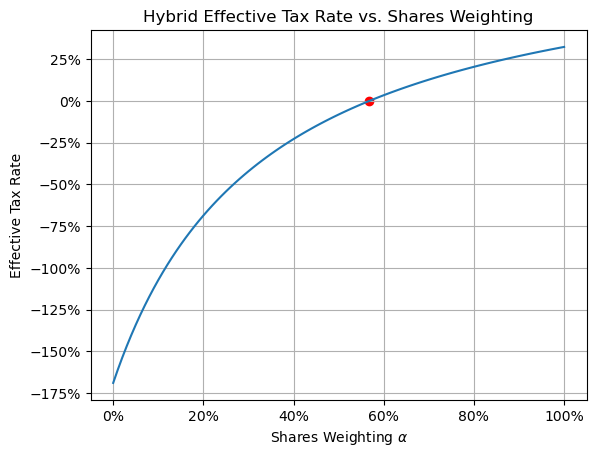

In [1016]:
def vis():
    alpha_untaxed_val = alpha_untaxed.subs(default_values).evalf()
    func = sp.lambdify([alpha], hybrid_effective_tax_rate.subs(default_values), "numpy")
    x = np.linspace(0, 1, 101)
    y = func(x) * 100
    x *= 100
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(x, y)
    print(alpha_untaxed_val)
    ax.scatter(alpha_untaxed_val * 100, 0, color="red")
    ax.grid(True)
    set_axes_percent(ax)
    ax.set_title("Hybrid Effective Tax Rate vs. Shares Weighting")
    ax.set_xlabel(f"Shares Weighting ${sp.latex(alpha)}$")
    ax.set_ylabel("Effective Tax Rate")
    maybe_save(fig, 'tax-neutral-weighting.png')

vis()

In [574]:
even_leverage_symbol = sp.symbols("lambda_e")
even_leverage = sp.solve(
    sp.Eq(
        housing_returns.subs(model_params).subs(base_tax_rate, 0),
        shares_returns,
    ),
    leverage,
)[0]
show(sp.Eq(even_leverage_symbol, even_leverage))

<IPython.core.display.Latex object>

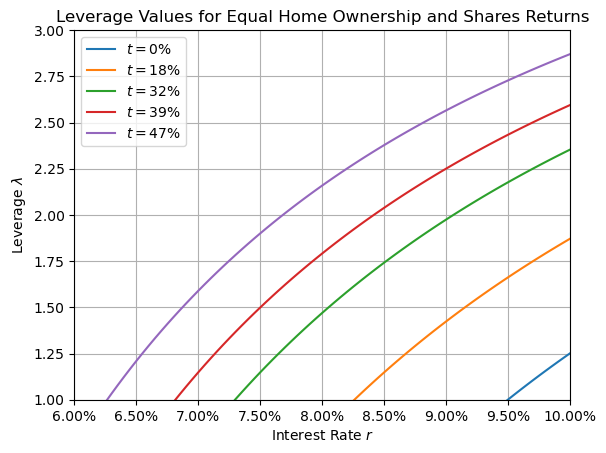

In [1017]:
def vis():
    vals = dict(default_values)
    del vals[interest_rate]
    r = np.linspace(0.05, 0.1, 101)
    func = sp.lambdify([interest_rate, base_tax_rate], even_leverage.subs(vals), "numpy")
    even_leverages = func(r, marginal_tax_rates_np[:, np.newaxis])
    fig = plt.figure()
    ax = plt.gca()
    for i, t in enumerate(marginal_tax_rates_np):
        ax.plot(
            r * 100,
            even_leverages[i],
            color=get_color(i),
            label=f"${sp.latex(base_tax_rate)}={t*100:.0f}\\%$",
        )
    set_axes_percent(ax, y=False)
    ax.grid(True)
    ax.set_ylim(1, 3)
    ax.set_xlim(6, 10)
    ax.set_ylabel(f"Leverage ${sp.latex(leverage)}$")
    ax.set_xlabel(f"Interest Rate ${sp.latex(interest_rate)}$")
    ax.legend()
    ax.set_title("Leverage Values for Equal Home Ownership and Shares Returns")
    maybe_save(fig, 'even-leverage-vs-interest-rate.png')

vis()

In [578]:
government_shared_equity_fraction = sp.symbols("g")
shared_equity_returns = leverage / (1 - government_shared_equity_fraction) * housing_yield + leverage * housing_capital_growth - (leverage - 1) * interest_rate
shared_equity_returns_symbol = sp.symbols("R_og")
show(sp.Eq(shared_equity_returns_symbol, shared_equity_returns))
shared_equity_even_leverage = sp.solve(
    sp.Eq(
        shared_equity_returns.subs(model_params),
        shares_returns,
    ),
    leverage,
)[0]

<IPython.core.display.Latex object>

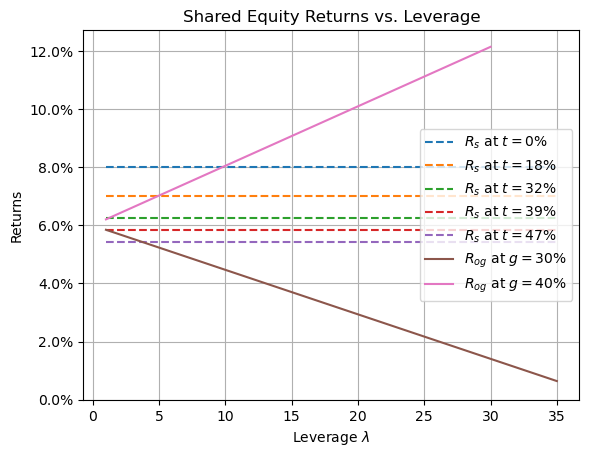

In [995]:
def vis():
    vals = dict(default_values)
    vals[interest_rate] = 0.06
    shares_returns_np = sp.lambdify(
        [base_tax_rate],
        shares_returns.subs(vals),
        "numpy",
    )(marginal_tax_rates_np)
    max_plot_leverage = 35
    shared_equity_func = sp.lambdify(
        [leverage, government_shared_equity_fraction],
        shared_equity_returns.subs(model_params).subs(vals),
    )
    fig = plt.figure()
    ax = plt.gca()
    for i, si in enumerate(shares_returns_np):
        ax.hlines(
            si * 100,
            1,
            max_plot_leverage,
            color=get_color(i),
            linestyle="dashed",
            label=f"${sp.latex(shares_returns_symbol)}$ at ${base_tax_rate}={marginal_tax_rates_np[i]*100:.0f}\\%$",
        )
    for i, (g_frac, leverage_val) in enumerate(((0.3, 35), (0.4, 30))):
        leverages_np = np.array([1, leverage_val], dtype=np.float32)
        se_returns = shared_equity_func(leverages_np, g_frac)
        ax.plot(
            leverages_np,
            se_returns * 100,
            color=get_color(shares_returns_np.size + i),
            label=f"${sp.latex(shared_equity_returns_symbol)}$ at ${sp.latex(government_shared_equity_fraction)}={g_frac*100:.0f}\\%$",
        )
    ax.legend()
    ax.set_title("Shared Equity Returns vs. Leverage")
    ax.set_xlabel(f"Leverage ${sp.latex(leverage)}$")
    ax.set_ylabel("Returns")
    ax.set_ylim(0)
    
    set_axes_percent(ax, x=False)
    ax.grid(True)
    maybe_save(fig, 'shared-equity-returns.png')

vis()

Even leverage value: 1.7917
{'Shares Only': 7.013667033252594, 'Interest Only': 6.558472761945499, 'Fixed Term': 6.887801669053307, 'Repay ASAP': 7.314068199666803, 'Delayed Buy': 7.658871563729594, 'Delayed Sell': 6.629878227394369}


100%|██████████| 10949/10949 [00:00<00:00, 15372.30it/s]


delayed buy critical:  7.658871563729603 7.658871563729594 7.658871642145293
Difference: 8.881784197001252e-15
3148 3146
delayed sell critical:  6.629878227394318 6.629878227394369 7.013787375478445
Difference: -5.062616992290714e-14
0 5200


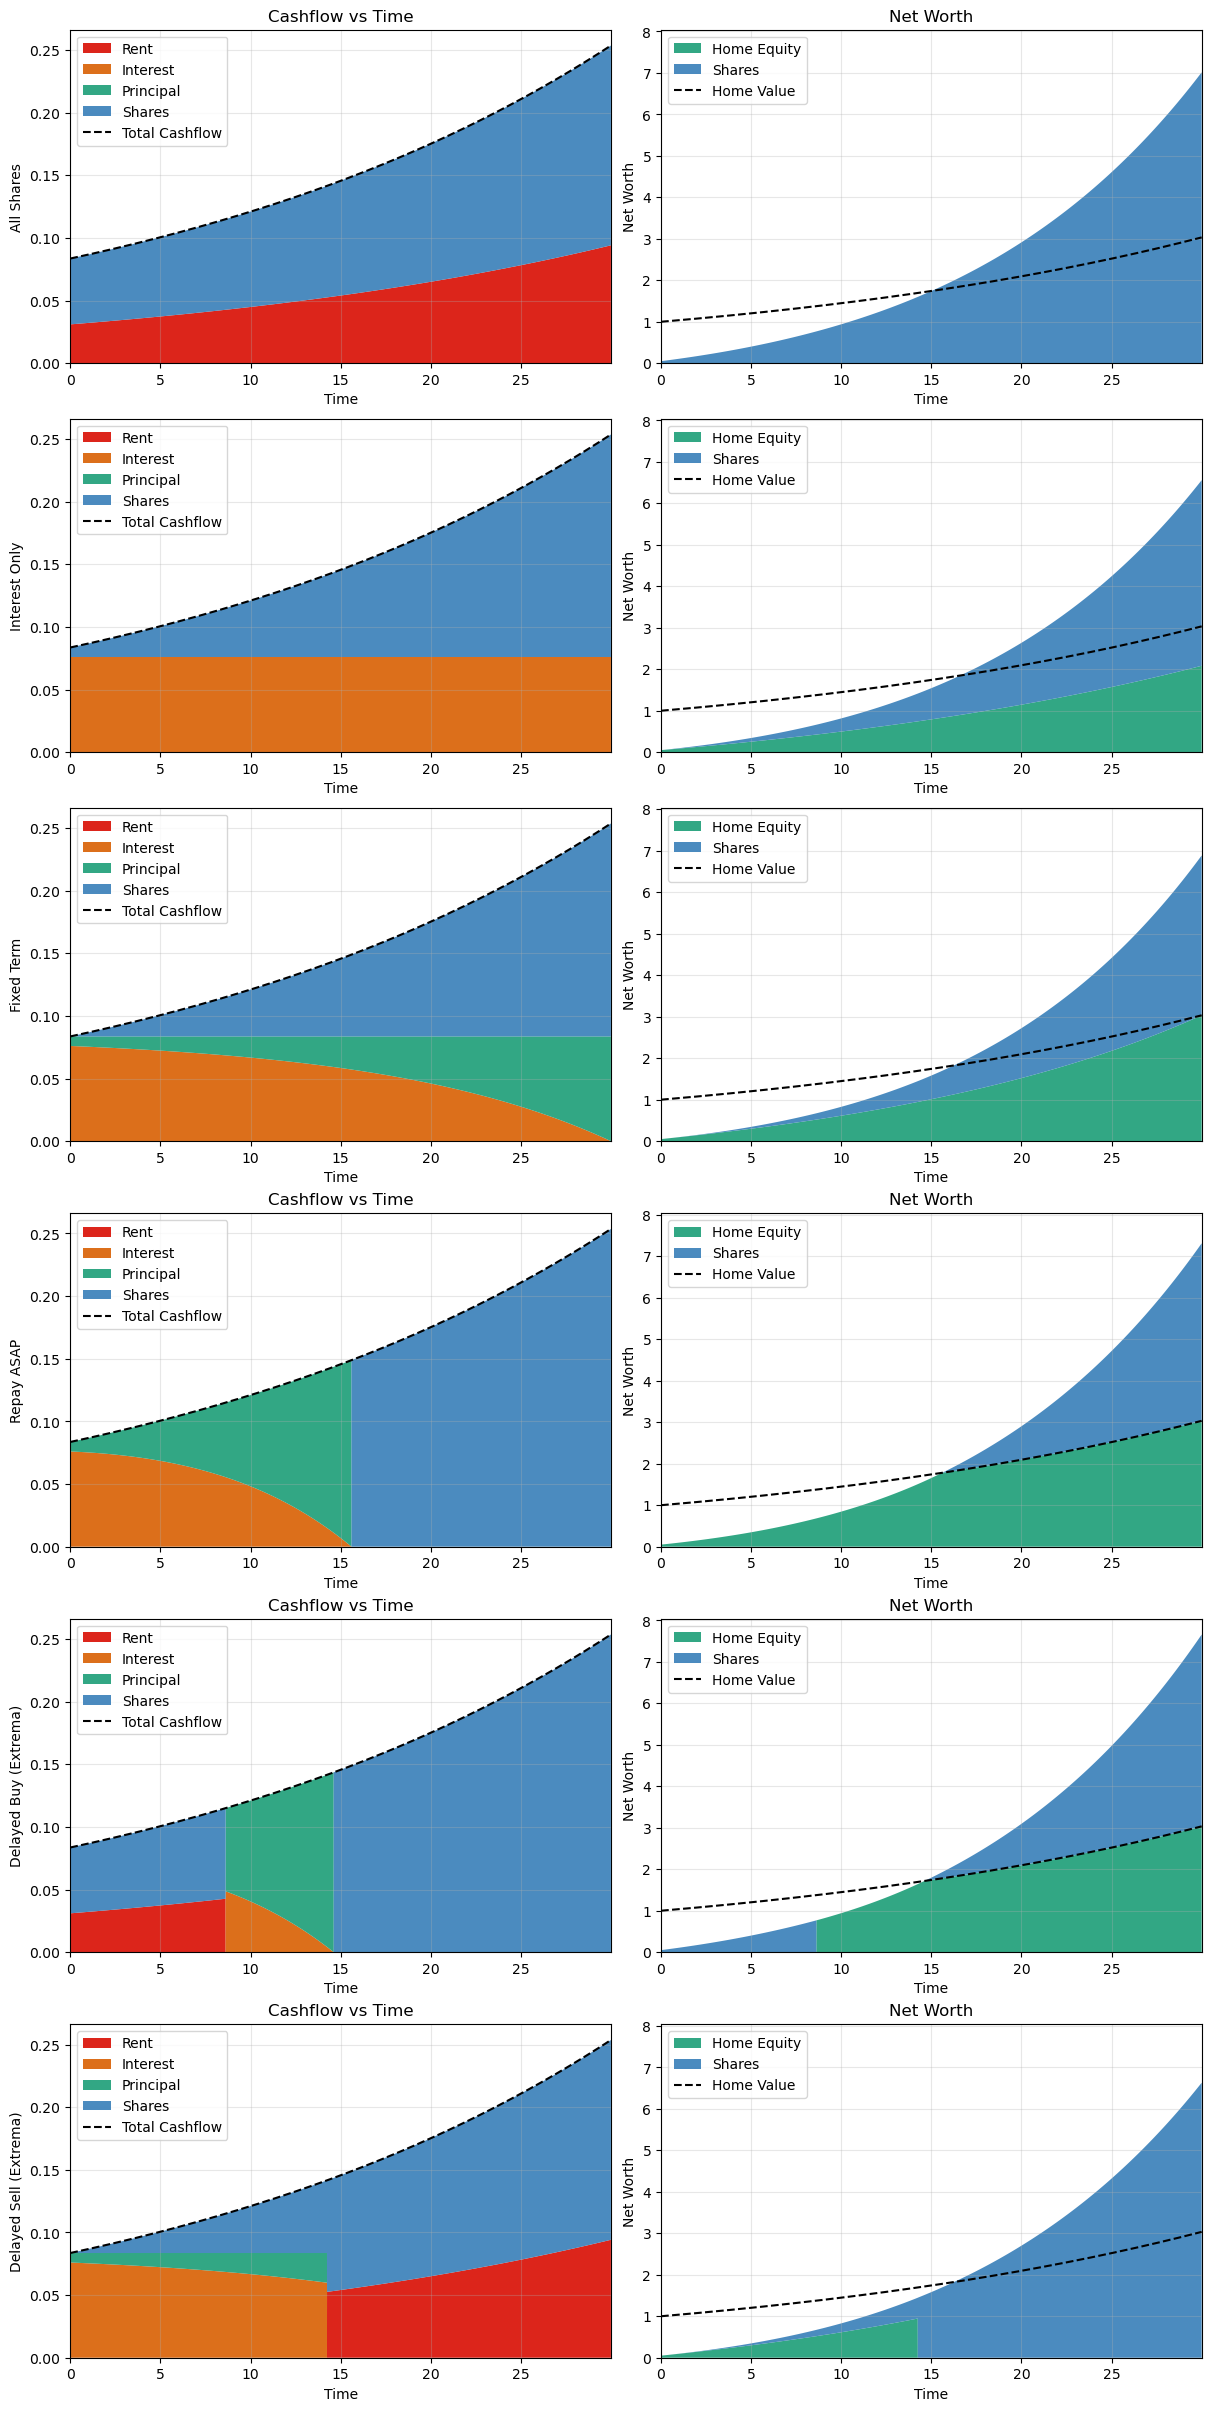

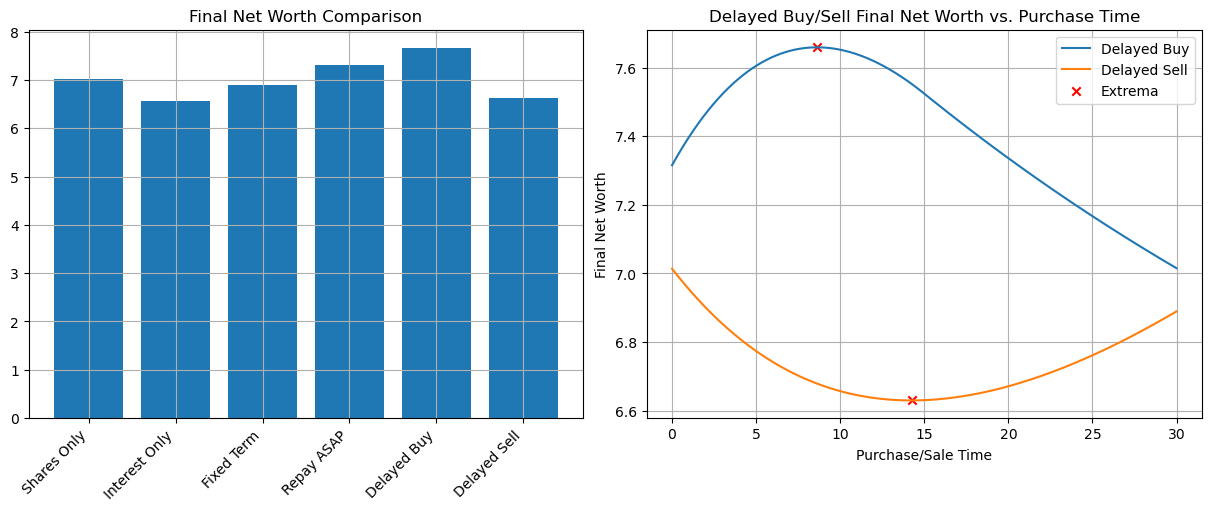

In [1026]:
def get_repayments(
    initial_loan_value: float,
    interest_rate: float,
    periods: int,
) -> float:
    return (
        interest_rate
        * initial_loan_value
        * (1 + interest_rate) ** periods
        / ((1 + interest_rate) ** periods - 1)
    )


def get_interest_only_cashflow(
    initial_loan_value: float,
    interest_rate: float,
    periods: int,
) -> np.ndarray:
    interest_repayments = np.full((periods,), initial_loan_value * interest_rate)
    principal_repayments = np.zeros((periods,))
    loan_value = np.full((periods,), initial_loan_value)
    return interest_repayments, principal_repayments, loan_value


def get_fixed_term_cashflow(
    initial_loan_value: float,
    interest_rate: float,
    periods: int,
) -> np.ndarray:
    repayment = get_repayments(initial_loan_value, interest_rate, periods)
    interest_repayments = np.zeros((periods,))
    principal_repayments = np.zeros((periods,))
    loan_value = np.zeros((periods,))
    remaining_loan = initial_loan_value
    for t in range(periods):
        interest_payment = remaining_loan * interest_rate
        principal_payment = repayment - interest_payment
        interest_repayments[t] = interest_payment
        principal_repayments[t] = principal_payment
        remaining_loan -= principal_payment
        loan_value[t] = remaining_loan
    return interest_repayments, principal_repayments, loan_value


def get_asap_repayment_cashflow(
    total_cashflow: np.ndarray,
    initial_loan_value: float,
    interest_rate: float,
    periods: int,
):
    interest_repayments = np.zeros((periods,))
    principal_repayments = np.zeros((periods,))
    loan_value = np.zeros((periods,))
    remaining_loan = initial_loan_value
    for t in range(periods):
        interest_due = remaining_loan * interest_rate
        remaining_loan += interest_due
        interest_repayment = min(total_cashflow[t], interest_due)
        remaining_loan -= interest_repayment
        principal_repayment = min(
            total_cashflow[t] - interest_repayment, remaining_loan
        )
        remaining_loan -= principal_repayment
        interest_repayments[t] = interest_repayment
        principal_repayments[t] = principal_repayment
        loan_value[t] = remaining_loan
        if remaining_loan <= 0:
            break
    return interest_repayments, principal_repayments, loan_value


def get_final_shares_value(
    *,
    initial_value: float = 0.0,
    shares_cashflow: np.ndarray,
    shares_return: float,
) -> float:
    factor = shares_return + 1
    n = shares_cashflow.shape[0]
    return (
        initial_value * (factor**n)
        + (factor ** np.arange(n - 1, -1, -1) * shares_cashflow).sum()
    )
    # v = initial_value
    # factor = shares_return + 1
    # for i in range(shares_cashflow.shape[0]):
    #     v = v * factor + shares_cashflow[i]
    # return v


def get_shares_value(
    *,
    initial_value: float = 0.0,
    shares_cashflow: np.ndarray,
    shares_return: float,
) -> np.ndarray:
    cumulative_value = np.zeros_like(shares_cashflow)
    v = initial_value
    factor = shares_return + 1
    for i in range(shares_cashflow.shape[0]):
        v = v * factor + shares_cashflow[i]
        cumulative_value[i] = v
    return cumulative_value


def simulate_all(
    suffix: str,
    *,
    periods_per_year: int = 365,
    years: int = 30,
    initial_value: float = 0.2,
    sub_values: tp.Dict[sp.Symbol, float] = {},
):

    def do_plot(
        ax0: plt.Axes,
        ax1: plt.Axes,
        t: np.ndarray,
        rent: np.ndarray,
        interest_cashflow: np.ndarray,
        principal_cashflow: np.ndarray,
        shares_cashflow: np.ndarray,
        home_equity_value: np.ndarray,
        shares_value: np.ndarray,
        scale_factor: tp.Optional[float] = None,
        plot_alpha: float = 0.9,
        grid_alpha: float = 0.3,
        total_cashflow: tp.Optional[np.ndarray] = None,
        label: tp.Optional[str] = None,
        net_worth_lim: tp.Optional[float] = None,
        set_titles: bool = True,
    ):
        if scale_factor is not None:
            rent = rent * scale_factor
            interest_cashflow = interest_cashflow * scale_factor
            principal_cashflow = principal_cashflow * scale_factor
            shares_cashflow = shares_cashflow * scale_factor
            if total_cashflow is not None:
                total_cashflow = total_cashflow * scale_factor

        ax0.stackplot(
            t,
            rent,
            interest_cashflow,
            principal_cashflow,
            shares_cashflow,
            labels=("Rent", "Interest", "Principal", "Shares"),
            colors=("#d90d02", "#d95f02", "#1b9e77", "#377eb8"),
            alpha=plot_alpha,
        )
        if total_cashflow is not None:
            ax0.plot(t, total_cashflow, "--", color="black", label="Total Cashflow")
        if set_titles:
            ax0.set_title("Cashflow vs Time")
        ax0.set_xlabel("Time")
        ax0.set_ylabel(label)
        ax1.stackplot(
            t,
            home_equity_value,
            shares_value,
            labels=("Home Equity", "Shares"),
            colors=("#1b9e77", "#377eb8"),
            alpha=plot_alpha,
        )
        ax1.plot(t, house_value, "--", color="black", label="Home Value")
        if government_shared_equity_fraction_val > 0:
            ax1.plot(
                t,
                discounted_house_value,
                ":",
                color="black",
                label="Discounted Home Value",
            )
        if set_titles:
            ax1.set_title("Net Worth")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Net Worth")
        if net_worth_lim is not None:
            ax1.set_ylim(0, net_worth_lim * 1.05)
        for ax in (ax0, ax1):
            ax.legend()
            ax.margins(x=0)
            ax.grid(alpha=grid_alpha)

    def eval_symbolic(x):
        ev = x.subs(model_params).subs(sub_values).subs(default_values).evalf()
        if not ev.is_number:
            raise ValueError(f"Could not evaluate symbolic expression: {x}")
        return float(ev)

    periods = periods_per_year * years
    shares_returns_val = eval_symbolic(shares_returns) / periods_per_year
    wages_growth_val = eval_symbolic(wages_growth) / periods_per_year
    interest_rate_val = eval_symbolic(interest_rate) / periods_per_year
    housing_yield_val = eval_symbolic(housing_yield) / periods_per_year
    government_shared_equity_fraction_val = eval_symbolic(
        government_shared_equity_fraction
    )

    t = np.arange(periods) / periods_per_year
    house_value = (1 + wages_growth_val) ** np.arange(periods)
    rent = housing_yield_val * house_value
    discounted_house_value = house_value * (1 - government_shared_equity_fraction_val)
    no_rent = np.zeros_like(rent)

    initial_loan_value = 1 - government_shared_equity_fraction_val - initial_value

    base_repayment = get_repayments(initial_loan_value, interest_rate_val, periods)
    total_cashflow = base_repayment * ((1 + wages_growth_val) ** np.arange(periods))

    interest_only_interest, interest_only_principal, interest_only_loan = (
        get_interest_only_cashflow(initial_loan_value, interest_rate_val, periods)
    )
    interest_only_shares_cashflow = (
        total_cashflow - interest_only_interest - interest_only_principal
    )
    interest_only_shares_value = get_shares_value(
        shares_cashflow=interest_only_shares_cashflow, shares_return=shares_returns_val
    )
    interest_only_home_equity = discounted_house_value - interest_only_loan
    fixed_term_interest, fixed_term_principal, fixed_term_loan = (
        get_fixed_term_cashflow(initial_loan_value, interest_rate_val, periods)
    )
    fixed_term_shares_cashflow = (
        total_cashflow - fixed_term_interest - fixed_term_principal
    )
    fixed_term_shares_value = get_shares_value(
        shares_cashflow=fixed_term_shares_cashflow, shares_return=shares_returns_val
    )
    fixed_term_home_equity = discounted_house_value - fixed_term_loan
    asap_interest, asap_principal, asap_loan = get_asap_repayment_cashflow(
        total_cashflow, initial_loan_value, interest_rate_val, periods
    )
    asap_home_equity = discounted_house_value - asap_loan
    asap_shares_cashflow = total_cashflow - asap_interest - asap_principal
    asap_shares_value = get_shares_value(
        shares_cashflow=asap_shares_cashflow, shares_return=shares_returns_val
    )

    all_shares_shares_cashflow = total_cashflow - rent
    all_shares_shares_value = get_shares_value(
        shares_cashflow=all_shares_shares_cashflow,
        shares_return=shares_returns_val,
        initial_value=initial_value,
    )
    all_shares_interest = np.zeros((periods,))
    all_shares_principal = np.zeros((periods,))
    all_shares_rent = rent
    all_shares_home_equity = np.zeros((periods,))
    all_shares_shares_value

    even_leverage_val = eval_symbolic(shared_equity_even_leverage)

    print(f"Even leverage value: {even_leverage_val:.4f}")
    # Delayed Buy
    if even_leverage_val <= 1:
        (
            delayed_buy_interest,
            delayed_buy_principal,
            delayed_buy_shares_cashflow,
            delayed_buy_rent,
            delayed_buy_home_equity,
            delayed_buy_shares_value,
        ) = (
            all_shares_interest,
            all_shares_principal,
            all_shares_shares_cashflow,
            all_shares_rent,
            all_shares_home_equity,
            all_shares_shares_value,
        )
    else:
        buy_index = np.where(
            all_shares_shares_value >= discounted_house_value / even_leverage_val
        )[0][0]
        delayed_buy_interest = np.zeros_like(fixed_term_interest)
        delayed_buy_principal = np.zeros_like(fixed_term_principal)
        delayed_buy_shares_cashflow = np.zeros_like(total_cashflow)

        delayed_asap_initial_loan_value = (
            discounted_house_value[buy_index] - all_shares_shares_value[buy_index]
        )
        (
            delayed_asap_interest_tail,
            delayed_asap_principal_tail,
            delayed_asap_loan_tail,
        ) = get_asap_repayment_cashflow(
            total_cashflow=total_cashflow[buy_index:],
            initial_loan_value=delayed_asap_initial_loan_value,
            interest_rate=interest_rate_val,
            periods=periods - buy_index,
        )
        delayed_buy_interest[buy_index:] = delayed_asap_interest_tail
        delayed_buy_principal[buy_index:] = delayed_asap_principal_tail
        delayed_buy_shares_cashflow = np.copy(total_cashflow)
        delayed_buy_shares_cashflow[:buy_index] -= rent[:buy_index]
        delayed_buy_shares_cashflow[buy_index:] -= (
            delayed_asap_interest_tail + delayed_asap_principal_tail
        )
        delayed_buy_home_equity = np.zeros_like(discounted_house_value)
        delayed_buy_home_equity[buy_index:] = (
            discounted_house_value[buy_index:] - delayed_asap_loan_tail
        )
        delayed_buy_shares_value = np.copy(all_shares_shares_value)
        delayed_buy_shares_value[buy_index:] = get_shares_value(
            shares_cashflow=delayed_buy_shares_cashflow[buy_index:],
            shares_return=shares_returns_val,
        )
        delayed_buy_rent = np.zeros_like(rent)
        delayed_buy_rent[:buy_index] = rent[:buy_index]

    # Delayed Sell
    (
        delayed_sell_interest,
        delayed_sell_principal,
        delayed_sell_shares_cashflow,
        delayed_sell_rent,
        delayed_sell_home_equity,
        delayed_sell_shares_value,
    ) = (
        x.copy()
        for x in (
            fixed_term_interest,
            fixed_term_principal,
            fixed_term_shares_cashflow,
            no_rent,
            fixed_term_home_equity,
            fixed_term_shares_value,
        )
    )
    if even_leverage_val > 1:
        sell_index = np.where(
            discounted_house_value / fixed_term_home_equity <= even_leverage_val
        )[0][0]
        delayed_sell_interest[sell_index:] = 0
        delayed_sell_principal[sell_index:] = 0
        delayed_sell_home_equity[sell_index:] = 0
        delayed_sell_rent[sell_index:] = rent[sell_index:]
        delayed_sell_shares_cashflow[sell_index:] = all_shares_shares_cashflow[
            sell_index:
        ]
        delayed_sell_shares_value[sell_index:] = get_shares_value(
            initial_value=fixed_term_shares_value[sell_index]
            + fixed_term_home_equity[sell_index],
            shares_cashflow=delayed_sell_shares_cashflow[sell_index:],
            shares_return=shares_returns_val,
        )

    shares_only_net_worth = all_shares_shares_value
    interest_only_net_worth = interest_only_home_equity + interest_only_shares_value
    fixed_term_net_worth = fixed_term_home_equity + fixed_term_shares_value
    asap_net_worth = asap_home_equity + asap_shares_value
    delayed_buy_net_worth = delayed_buy_home_equity + delayed_buy_shares_value
    delayed_sell_net_worth = delayed_sell_home_equity + delayed_sell_shares_value

    net_worths = {
        "Shares Only": shares_only_net_worth,
        "Interest Only": interest_only_net_worth,
        "Fixed Term": fixed_term_net_worth,
        "Repay ASAP": asap_net_worth,
        "Delayed Buy": delayed_buy_net_worth,
        "Delayed Sell": delayed_sell_net_worth,
    }

    net_worth_lim = max(v.max() for v in net_worths.values())

    n = len(net_worths)
    fig, ax = plt.subplots(n, 2, figsize=(12, 4 * n), layout="constrained")
    do_plot(
        ax[0, 0],
        ax[0, 1],
        t,
        all_shares_rent,
        all_shares_interest,
        all_shares_principal,
        all_shares_shares_cashflow,
        all_shares_home_equity,
        all_shares_shares_value,
        scale_factor=periods_per_year,
        total_cashflow=total_cashflow,
        set_titles=True,
        net_worth_lim=net_worth_lim,
        label="All Shares",
    )
    do_plot(
        ax[1, 0],
        ax[1, 1],
        t,
        no_rent,
        interest_only_interest,
        interest_only_principal,
        interest_only_shares_cashflow,
        interest_only_home_equity,
        interest_only_shares_value,
        scale_factor=periods_per_year,
        total_cashflow=total_cashflow,
        set_titles=False,
        net_worth_lim=net_worth_lim,
        label="Interest Only",
    )
    do_plot(
        ax[2, 0],
        ax[2, 1],
        t,
        no_rent,
        fixed_term_interest,
        fixed_term_principal,
        fixed_term_shares_cashflow,
        fixed_term_home_equity,
        fixed_term_shares_value,
        scale_factor=periods_per_year,
        total_cashflow=total_cashflow,
        set_titles=False,
        net_worth_lim=net_worth_lim,
        label="Fixed Term",
    )
    do_plot(
        ax[3, 0],
        ax[3, 1],
        t,
        np.zeros_like(rent),
        asap_interest,
        asap_principal,
        asap_shares_cashflow,
        asap_home_equity,
        asap_shares_value,
        scale_factor=periods_per_year,
        total_cashflow=total_cashflow,
        set_titles=True,
        net_worth_lim=net_worth_lim,
        label="Repay ASAP",
    )
    do_plot(
        ax[4, 0],
        ax[4, 1],
        t,
        delayed_buy_rent,
        delayed_buy_interest,
        delayed_buy_principal,
        delayed_buy_shares_cashflow,
        delayed_buy_home_equity,
        delayed_buy_shares_value,
        scale_factor=periods_per_year,
        total_cashflow=total_cashflow,
        set_titles=True,
        net_worth_lim=net_worth_lim,
        label="Delayed Buy (Extrema)",
    )
    do_plot(
        ax[5, 0],
        ax[5, 1],
        t,
        delayed_sell_rent,
        delayed_sell_interest,
        delayed_sell_principal,
        delayed_sell_shares_cashflow,
        delayed_sell_home_equity,
        delayed_sell_shares_value,
        scale_factor=periods_per_year,
        total_cashflow=total_cashflow,
        set_titles=True,
        net_worth_lim=net_worth_lim,
        label="Delayed Sell (Extrema)",
    )
    maybe_save(fig, f'cashflows-{suffix}.png')

    # plt.figure()
    # ax = plt.gca()
    # for label, net_worth in net_worths.items():
    #     ax.plot(t, net_worth, label=label)
    # ax.set_title("Net Worth Comparison")
    # ax.set_xlabel("Time")
    # ax.set_ylabel("Net Worth")
    # ax.legend()
    # ax.grid(True)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
    ax: plt.Axes = axes[0]
    final_net_worths = {k: v[-1] for k, v in net_worths.items()}
    keys, values = zip(*final_net_worths.items())
    ax.bar(keys, values)
    ax.grid(True)
    plt.sca(ax)
    plt.xticks(rotation=45, ha="right")
    ax.set_title("Final Net Worth Comparison")
    print({k: v[-1] for k, v in net_worths.items()})

    def get_delayed_buy_final_net_worth(buy_index: int):
        initial_loan_value = (
            discounted_house_value[buy_index] - all_shares_shares_value[buy_index]
        )
        (
            interest_tail,
            principal_tail,
            loan_tail,
        ) = get_asap_repayment_cashflow(
            total_cashflow=total_cashflow[buy_index:],
            initial_loan_value=initial_loan_value,
            interest_rate=interest_rate_val,
            periods=periods - buy_index,
        )
        final_house_equity = discounted_house_value[-1] - loan_tail[-1]

        shares_cashflow = total_cashflow[buy_index:] - (interest_tail + principal_tail)
        final_shares_value = get_final_shares_value(
            shares_cashflow=shares_cashflow,
            shares_return=shares_returns_val,
        )
        return final_house_equity + final_shares_value

    def get_delayed_sell_final_net_worth(sell_index: int):
        return get_final_shares_value(
            initial_value=fixed_term_net_worth[sell_index],
            shares_cashflow=all_shares_shares_cashflow[sell_index:],
            shares_return=shares_returns_val,
        )

    delayed_buy_final = np.array(
        [get_delayed_buy_final_net_worth(i) for i in tqdm.trange(periods - 1)]
    )
    delayed_sell_final = np.array(
        [get_delayed_sell_final_net_worth(i) for i in tqdm.trange(periods - 1)]
    )

    ax = axes[1]
    ax.plot(t[:-1], delayed_buy_final, label="Delayed Buy")
    ax.plot(t[:-1], delayed_sell_final, label="Delayed Sell")
    ax.set_title("Delayed Buy/Sell Final Net Worth vs. Purchase Time")
    ax.set_xlabel("Purchase/Sale Time")
    ax.set_ylabel("Final Net Worth")
    ax.scatter(
        [t[buy_index], t[sell_index]],
        [delayed_buy_net_worth[-1], delayed_sell_net_worth[-1]],
        marker="x",
        color="red",
        label="Extrema",
    )
    ax.legend()
    ax.grid(True)
    print(
        "delayed buy critical: ",
        delayed_buy_final[buy_index],
        delayed_buy_net_worth[-1],
        delayed_buy_final.max(),
    )
    print("Difference:", delayed_buy_final[buy_index] - delayed_buy_net_worth[-1])
    print(np.argmax(delayed_buy_final), buy_index)
    print(
        "delayed sell critical: ",
        delayed_sell_final[sell_index],
        delayed_sell_net_worth[-1],
        delayed_sell_final.max(),
    )
    print("Difference:", delayed_sell_final[sell_index] - delayed_sell_net_worth[-1])
    print(np.argmax(delayed_sell_final), sell_index)
    maybe_save(fig, f'net-worths-{suffix}.png')


# simulate_all(
#     suffix='shared-equity-40',
#     periods_per_year=365,
#     initial_value=0.02,
#     sub_values={
#         interest_rate: 0.06,
#         base_tax_rate: marginal_tax_rates_np[2],
#         government_shared_equity_fraction: 0.4,
#     },
# )
# simulate_all(
#     suffix='shared-equity-30',
#     periods_per_year=365,
#     initial_value=0.02,
#     sub_values={
#         interest_rate: 0.06,
#         base_tax_rate: marginal_tax_rates_np[-1],
#         government_shared_equity_fraction: 0.3,
#     },
# )
# simulate_all(
#     suffix='deposit-05',
#     periods_per_year=365,
#     initial_value=0.05,
#     sub_values={
#         interest_rate: 0.08,
#         base_tax_rate: marginal_tax_rates_np[-2],
#         government_shared_equity_fraction: 0,
#     },
)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.06371199999999998
0.06378205128205125


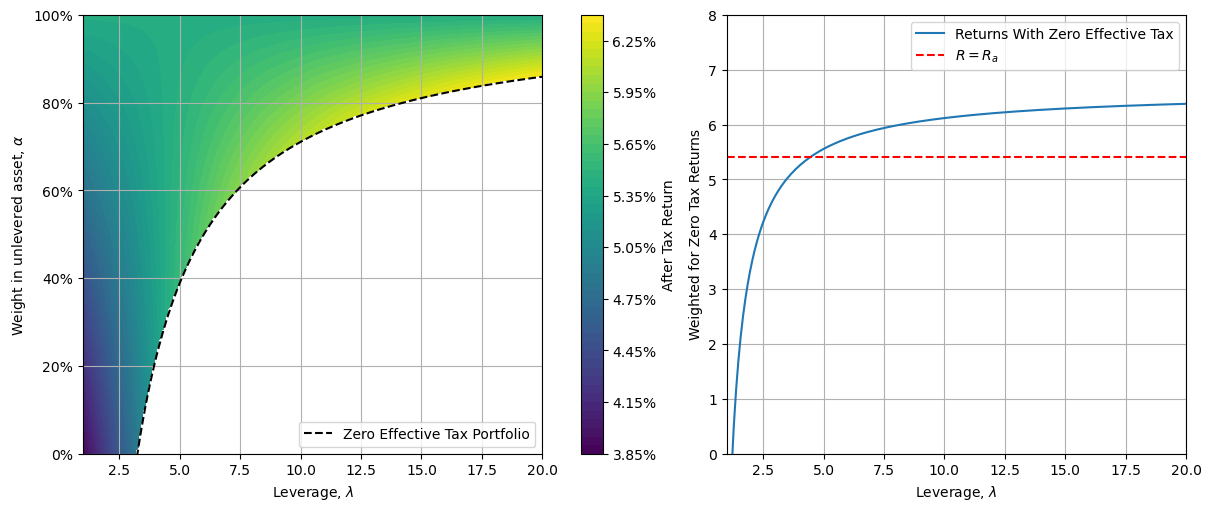

In [1018]:
def vis():
    c_a = sp.symbols("c_a")
    y_a = sp.symbols("y_a")
    c_b = sp.symbols("c_b")
    y_b = sp.symbols("y_b")
    weight = sp.symbols("alpha")

    values = {
        c_a: 0.05,
        y_a: 0.03,
        c_b: 0.03,
        y_b: 0.03,
        interest_rate: 0.065,
        cgt_discount: 0.5,
        base_tax_rate: marginal_tax_rates_np[-1],
    }

    R_a_symbol = sp.symbols("R_a")
    R_a = levered_returns.subs(
        {
            capital_growth: c_a,
            investment_yield: y_a,
            leverage: 1,
        }
    )
    R_a_val = R_a.subs(values).evalf()
    show(levered_returns)
    show(sp.Eq(R_a_symbol, R_a))
    show(sp.Eq(R_a_symbol, R_a.subs(values).evalf()))
    R_b_symbol = sp.symbols("R_b")
    R_b = levered_returns.subs(
        {
            capital_growth: c_b,
            investment_yield: y_b,
        }
    )
    R_b_val = R_b.subs(values).subs(leverage, 1).evalf()
    show(sp.Eq(R_b_symbol, R_b))
    show(sp.Eq(R_b_symbol, R_b.subs(values).subs(leverage, 1)).evalf())
    total_return = weight * R_a + (1 - weight) * R_b
    show(sp.Eq(sp.symbols("R_alpha"), total_return))
    show(sp.Eq(sp.symbols("R_alpha"), total_return.subs(values).expand().collect([weight, leverage])))

    pre_tax_return = total_return.subs(base_tax_rate, 0)
    tax_paid = pre_tax_return - total_return
    critical_weight = sp.solve(sp.Eq(tax_paid, 0), weight)[0]
    show(sp.Eq(sp.symbols("alpha_*"), critical_weight))
    critical_returns = total_return.subs(weight, critical_weight)
    critical_leverage = sp.solve(
        sp.Eq(critical_returns, R_a), leverage
    )[0]
    show(sp.Eq(sp.symbols("lambda_*"), critical_leverage))
    critical_leverage_val = critical_leverage.subs(values).evalf()
    show(sp.Eq(sp.symbols("lambda_*"), critical_leverage_val))
    show(sp.Eq(sp.symbols("R_*"), critical_returns.expand().simplify()))
    show(
        sp.Eq(
            sp.symbols("R_*"), critical_returns.expand().simplify().subs(values).evalf()
        )
    )
    returns_func = sp.lambdify([leverage, weight], total_return.subs(values), "numpy")
    critical_weight_func = sp.lambdify(
        [leverage], critical_weight.subs(values), "numpy"
    )
    critical_returns_func = sp.lambdify(
        [leverage], critical_returns.subs(values), "numpy"
    )
    leverage_lim = 20
    leverages = np.linspace(1, leverage_lim, 201)
    weights = np.linspace(0, 1, 201)
    l, w = np.meshgrid(leverages, weights, indexing="ij")
    mask = w >= critical_weight_func(l)
    returns = returns_func(l, w)
    # returns[-1, :] = sp.lambdify([leverage], R_a.subs(values), "numpy")(leverages)
    returns[~mask] = np.nan
    critical_returns_vals = critical_returns_func(leverages)
    print(returns[mask].max())
    print(critical_returns_vals.max())
    critical_weights = critical_weight_func(leverages)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
    ax: plt.Axes = axes[0]
    cs = ax.contourf(
        l,
        w * 100,
        returns * 100,
        levels=50,
        cmap="viridis",
    )
    set_axes_percent(ax, x=False)
    cbar = plt.colorbar(cs, ax=ax, label="After Tax Return")
    cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.plot(leverages, critical_weights * 100, color="black", linestyle="dashed", label="Zero Effective Tax Portfolio")
    ax.legend(loc="lower right")
    ax.set_xlabel(f"Leverage, ${sp.latex(leverage)}$")
    ax.set_ylabel(f"Weight in unlevered asset, ${sp.latex(weight)}$")
    ax.grid(True)
    ax.set_xlim(1, leverage_lim)
    ax.set_ylim(0, 100)

    ax = axes[1]
    ax.plot(leverages, critical_returns_vals * 100, label="Returns With Zero Effective Tax")
    ax.hlines(R_a_val * 100, 1, leverage_lim, color="red", linestyle="dashed", label=f"${sp.latex(general_returns_symbol)} = {sp.latex(R_a_symbol)}$")
    # ax.hlines(R_b_val * 100, 1, leverage_lim, color="green", linestyle="dashed", label=f"${sp.latex(general_returns_symbol)} = {sp.latex(R_b_symbol)}$, unlevered")
    # ax.vlines(critical_leverage_val, 0, R_a_val * 100, color="green", linestyle="dashed")
    ax.set_xlabel(f"Leverage, ${sp.latex(leverage)}$")
    ax.set_ylabel(f"Weighted for Zero Tax Returns")
    ax.grid(True)
    ax.legend()
    ax.set_xlim(1, leverage_lim)
    ax.set_ylim(0, 8)
    maybe_save(fig, 'simple-weighted-returns.png')


vis()

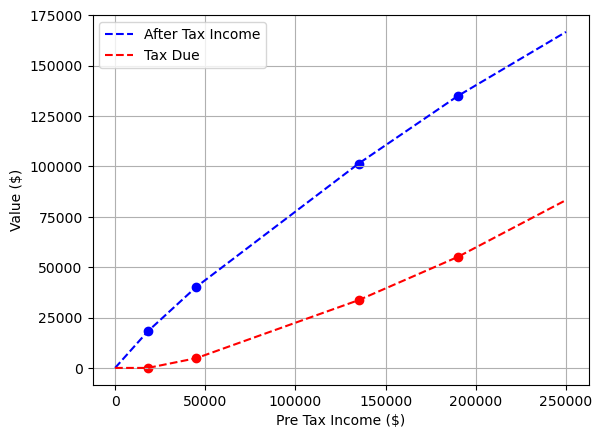

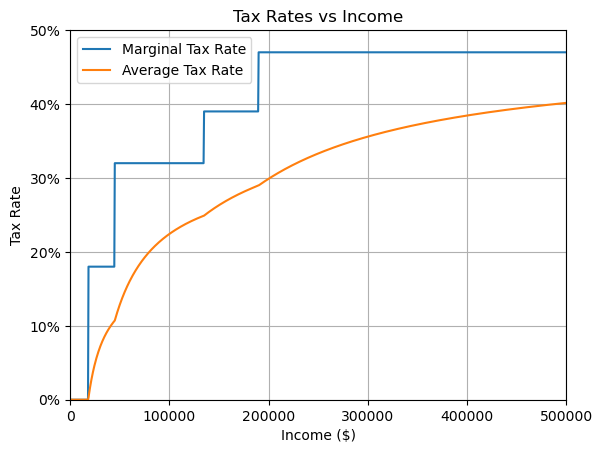

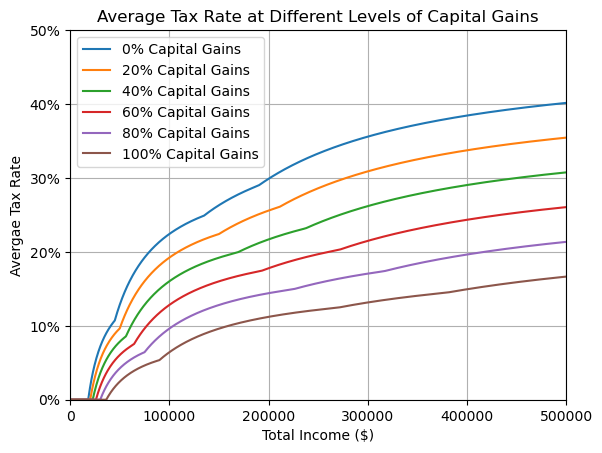

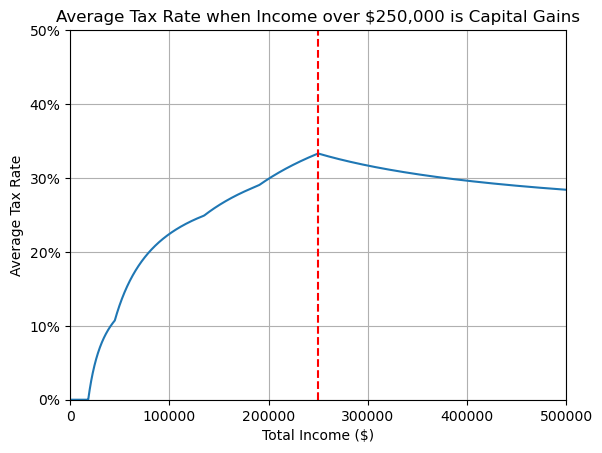

In [817]:
def vis():
    # bracket_limits = np.array([0, 18200, 26800, 45000, 135000, 190000])
    bracket_limits = np.array([0, 18200, 45000, 135000, 190000])
    offsets = np.zeros(bracket_limits.shape)
    for i in range(marginal_tax_rates_np.size - 1):
        offsets[i + 1] = offsets[i] + marginal_tax_rates_np[i] * (bracket_limits[i+1] - bracket_limits[i])
    def get_tax_bracket(income: np.ndarray) -> np.ndarray:
        out = np.full(income.shape, bracket_limits.size - 1, dtype=np.int32)
        for i in range(len(bracket_limits) - 1):
            lower = bracket_limits[i]
            upper = bracket_limits[i + 1]
            mask = (lower <= income) & (income < upper)
            out[mask] = i
        return out
        
    def get_marginal_tax_rate(income: np.ndarray) -> np.ndarray:
        bracket = get_tax_bracket(income)
        return marginal_tax_rates_np[bracket]


    def get_taxed_amount(income: np.ndarray) -> np.ndarray:
        bracket = get_tax_bracket(income)
        return offsets[bracket] + (income - bracket_limits[bracket]) * marginal_tax_rates_np[bracket]
    
    def get_discounted_taxed_amount(regular_income: np.ndarray, cg_income: np.ndarray):
        discounted_income = cg_income / 2 + regular_income
        return get_taxed_amount(discounted_income)

    def get_discounted_average_tax_rate(regular_income: np.ndarray, cg_income: np.ndarray):
        total_income = regular_income + cg_income
        taxed_amount = get_discounted_taxed_amount(regular_income, cg_income)
        average_rate = taxed_amount / total_income
        average_rate[total_income == 0] = 0
        return average_rate
    
    incomes = np.array([*bracket_limits, 250000])
    taxes = get_taxed_amount(incomes)
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(incomes, incomes - taxes, linestyle='dashed', color="blue", label="After Tax Income")
    ax.scatter(incomes[1:-1], incomes[1:-1] - taxes[1:-1], color="blue")
    ax.plot(incomes, taxes, linestyle='dashed', color="red", label="Tax Due")
    ax.scatter(incomes[1:-1], taxes[1:-1], color="red")
    ax.set_xlabel("Pre Tax Income ($)")
    ax.set_ylabel("Value ($)")
    ax.legend()
    ax.grid(True)
    maybe_save(fig, 'after-tax-income-vs-income.png')
    
    
    incomes = np.linspace(0, 500000, 1001)

    marginal_rates = get_marginal_tax_rate(incomes)
    taxes = get_taxed_amount(incomes)

    average_rates = taxes / incomes
    average_rates[incomes == 0] = 0
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(incomes, marginal_rates * 100, label="Marginal Tax Rate")
    ax.plot(incomes, average_rates * 100, label="Average Tax Rate")
    ax.set_xlabel("Income ($)")
    ax.set_ylabel("Tax Rate")
    ax.set_title("Tax Rates vs Income")
    ax.legend()
    ax.grid(True)
    set_axes_percent(ax, x=False)
    ax.set_ylim(0, 50)
    ax.set_xlim(0, 500000)
    maybe_save(fig, 'tax-rates-vs-income.png')

    fig = plt.figure()
    ax = plt.gca()
    n = 6
    for i in range(0, n):
        frac = i / (n - 1)
        ax.plot(incomes, get_discounted_average_tax_rate(incomes * (1 - frac), incomes * frac) * 100, label=f"{frac*100:.0f}% Capital Gains")
    ax.set_xlabel("Total Income ($)")
    ax.set_ylabel("Avergae Tax Rate")
    ax.legend()
    ax.set_title("Average Tax Rate at Different Levels of Capital Gains")
    set_axes_percent(ax, x=False)
    ax.grid(True)
    ax.set_ylim(0, 50)
    ax.set_xlim(0, 500000)
    maybe_save(fig, 'average-tax-rate-vs-capital-gains-fraction.png')


    regular_income_cutoff = 250000
    i = np.linspace(0, regular_income_cutoff, 1001)
    z = np.zeros_like(i)
    regular_income = np.concatenate([i, np.full_like(i, regular_income_cutoff)], axis=0)
    cg_income = np.concatenate([z, i], axis=0)
    total_income = regular_income + cg_income
    taxed_amount = get_discounted_taxed_amount(regular_income, cg_income)
    average_rate = taxed_amount / total_income
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(total_income, average_rate * 100)
    ax.vlines(regular_income_cutoff, 0, 50, color="red", linestyle="dashed")
    ax.set_xlabel("Total Income ($)")
    ax.set_ylabel("Average Tax Rate")
    ax.set_title("Average Tax Rate when Income over $250,000 is Capital Gains")
    ax.grid(True)
    set_axes_percent(ax, x=False)
    ax.set_ylim(0, 50)
    ax.set_xlim(0, 2 * regular_income_cutoff)
    maybe_save(fig, 'regressive-cgt-example.png')


vis()

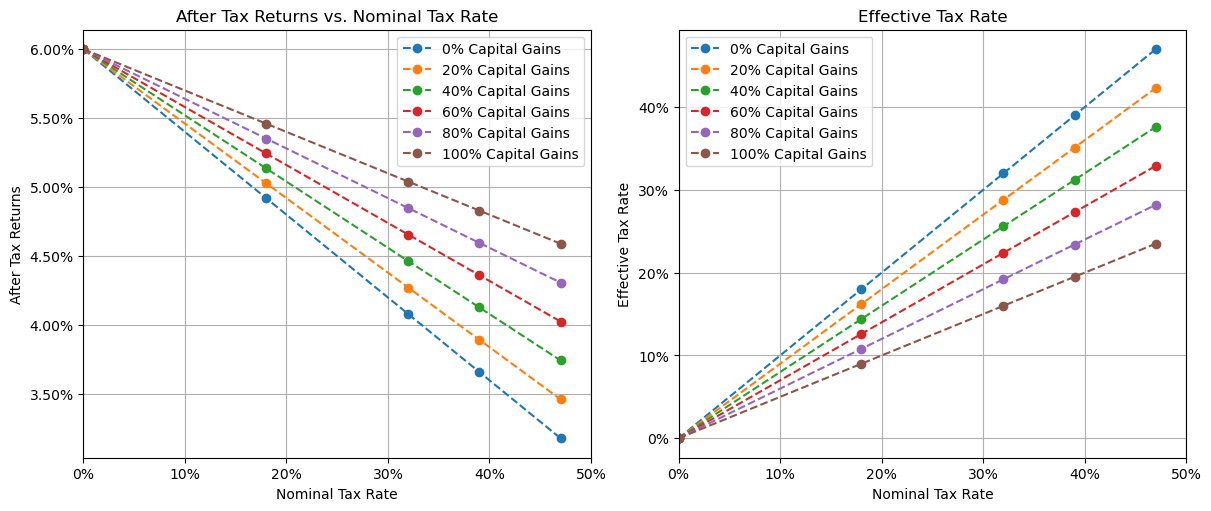

In [819]:
def vis(max_cg_frac: int=1, num_plots: int = 6):
    normal_return = 0.06
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")
    axs[0].set_title("After Tax Returns vs. Nominal Tax Rate")
    axs[0].set_xlabel("Nominal Tax Rate")
    axs[0].set_ylabel("After Tax Returns")
    axs[1].set_title("Effective Tax Rate")
    axs[1].set_xlabel("Nominal Tax Rate")
    axs[1].set_ylabel("Effective Tax Rate")
    for cg_frac in np.linspace(0, max_cg_frac, num_plots):
        params = {
            leverage: 1,
            capital_growth: normal_return * cg_frac,
            investment_yield: normal_return * (1 - cg_frac),
            cgt_discount: 0.5,
        }

        returns_np = sp.lambdify([base_tax_rate], levered_returns.subs(params), "numpy")(marginal_tax_rates_np)
        
        if isinstance(returns_np, float) or isinstance(returns_np, int):
            returns_np = np.full_like(marginal_tax_rates_np, returns_np)
        effective_tax_rate_np = sp.lambdify([base_tax_rate], effective_tax_rate.subs(params), "numpy")(marginal_tax_rates_np)
        
        if isinstance(effective_tax_rate_np, float) or isinstance(effective_tax_rate_np, int):
            effective_tax_rate_np = np.full_like(marginal_tax_rates_np, effective_tax_rate_np)
        ax: plt.Axes = axs[0]
        ax.plot(
            marginal_tax_rates_np * 100,
            returns_np * 100,
            label=f"{cg_frac*100:.0f}% Capital Gains",
            linestyle="dashed",
            marker='o',
        )
        ax = axs[1]
        ax.plot(
            marginal_tax_rates_np * 100,
            effective_tax_rate_np * 100,
            label=f"{cg_frac*100:.0f}% Capital Gains",
            linestyle="dashed",
            marker='o',
        )
    for ax in axs:
        set_axes_percent(ax)
        ax.set_xlim(0, 50)
        ax.grid(True)
        ax.legend()
    maybe_save(fig, 'nominal-tax-rate-effect.png')
    


vis()

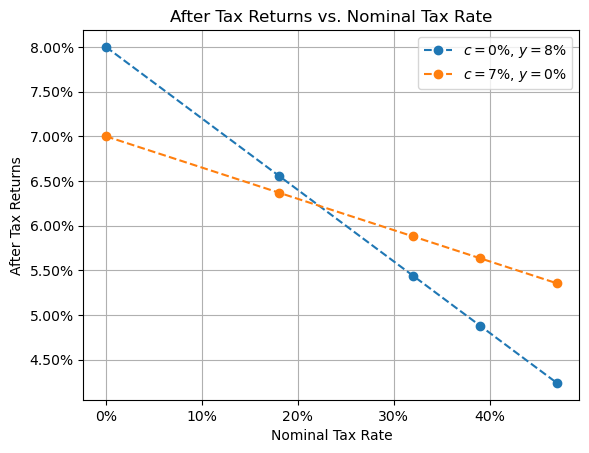

In [821]:
def vis():
    c_a = 0.0
    y_a = 0.08
    c_b = 0.07
    y_b = 0.0
    ra = levered_returns.subs(
        {
            leverage: 1,
            cgt_discount: 0.5,
            capital_growth: c_a,
            investment_yield: y_a,
        }
    )
    rb = levered_returns.subs(
        {
            leverage: 1,
            cgt_discount: 0.5,
            capital_growth: c_b,
            investment_yield: y_b,
        }
    )
    ra_values = sp.lambdify([base_tax_rate], ra, "numpy")(marginal_tax_rates_np)
    rb_values = sp.lambdify([base_tax_rate], rb, "numpy")(marginal_tax_rates_np)
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(
        marginal_tax_rates_np * 100,
        ra_values * 100,
        label=f"${sp.latex(capital_growth)}={c_a*100:.0f}\\%$, ${sp.latex(investment_yield)}={y_a*100:.0f}\\%$",
        linestyle="dashed",
        marker="o",
    )
    ax.plot(
        marginal_tax_rates_np * 100,
        rb_values * 100,
        label=f"${sp.latex(capital_growth)}={c_b*100:.0f}\\%$, ${sp.latex(investment_yield)}={y_b*100:.0f}\\%$",
        linestyle="dashed",
        marker="o",
    )
    ax.grid(True)
    set_axes_percent(ax)
    ax.set_xlabel("Nominal Tax Rate")
    ax.set_ylabel("After Tax Returns")
    ax.set_title("After Tax Returns vs. Nominal Tax Rate")
    ax.legend()
    maybe_save(fig, 'after-tax-returns-comparison.png')


vis()